## <u> Table of contents </u>

1. [Data](#data)

2. [EDA](#eda)

    - [Univariate](#univariate)

    - [Bivariate between features and target variable](#bivariate1) - Scatterplots, box plots

    - [Bivariate between features](#bivariate2) - Heatmap

3. [PCA](#pca)

4. [UMAP](#umap)

    - [Cluster analysis](#cluster)

5. [Feature engineering](#fe)

6. [Decision tree](#de)

    - [Optuna hyperparameter tuning](#de1)

7. [Random forest](#rf)

    - [Optuna hyperparameter tuning](#rf1)

8. [Extra trees](#et)

    - [Optuna hyperparameter tuning](#et1)

9. [Ada boost](#ab)

    - [Optuna hyperparameter tuning](#ab1)

10. [Predict test set](#pred)

In [1]:
# libraries
import os 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

import scipy.stats as stats
import statsmodels.api as sm 
from statsmodels.formula.api import ols

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn import tree
import lightgbm as lgb

import umap 
import optuna

/opt/anaconda3/envs/kaggle_flood/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

<a id='data'></a>
### Data

In [2]:
train_df = pd.read_csv('./dataset/train.csv')
train_df.shape

(1117957, 22)

In [91]:
test_df = pd.read_csv('./dataset/test.csv')
test_df.shape

(745305, 21)

---

<a id='eda'></a>
### EDA

In [4]:
train_df.head()

id  MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0   0                 5                   8                5              8   
1   1                 6                   7                4              4   
2   2                 6                   5                6              7   
3   3                 3                   4                6              5   
4   4                 5                   3                2              6   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             6              4            4          3                      3   
1             8              8            3          5                      4   
2             3              7            1          5                      4   
3             4              8            4          7                      6   
4             4              4            3          3                      3   

   ...  DrainageSystems  CoastalVulnerability  Landslides  Watersheds  \
0  ...                5                     3           3           5   
1  ...                7                     2           0           3   
2  ...                7                     3           7           5   
3  ...                2                     4           7           4   
4  ...                2                     2           6           6   

   DeterioratingInfrastructure  PopulationScore  WetlandLoss  \
0                            4                7            5   
1                            5                3            3   
2                            6                8            2   
3                            4                6            5   
4                            4                1            2   

   InadequatePlanning  PoliticalFactors  FloodProbability  
0                   7                 3             0.445  
1                   4                 3             0.450  
2                   3                 3             0.530  
3                   7                 5             0.535  
4                   3                 5             0.415  

[5 rows x 22 columns]

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117957 entries, 0 to 1117956
Data columns (total 22 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   id                               1117957 non-null  int64  
 1   MonsoonIntensity                 1117957 non-null  int64  
 2   TopographyDrainage               1117957 non-null  int64  
 3   RiverManagement                  1117957 non-null  int64  
 4   Deforestation                    1117957 non-null  int64  
 5   Urbanization                     1117957 non-null  int64  
 6   ClimateChange                    1117957 non-null  int64  
 7   DamsQuality                      1117957 non-null  int64  
 8   Siltation                        1117957 non-null  int64  
 9   AgriculturalPractices            1117957 non-null  int64  
 10  Encroachments                    1117957 non-null  int64  
 11  IneffectiveDisasterPreparedness  1117957 non-null 

In [6]:
# target variable 
min(train_df['FloodProbability'])

0.285

In [7]:
max(train_df['FloodProbability'])

0.725

<u> Notes: </u>

1. 21 columns and 1 target variable: `FloodProbability`
2. All variables are numeric
3. 1+ million rows 
4. No missing values

---

<a id='univariate'></a>
### Univariate analysis 

In [8]:
def plot_distribution(
        df: pd.DataFrame,
        variable: str
):
    """
    Plot histograms for specified variable while marking median, mean, lower and upper quartles

    """
    # descriptive stats 
    minimum = df[variable].min()
    maximum = df[variable].max()
    mean = df[variable].mean()
    median = df[variable].median()
    lower = np.percentile(df[variable], 25)
    upper = np.percentile(df[variable], 75)
    num_bins = int((max(df[variable]) - min(df[variable])) / 2)

    # histogram 
    plt.figure(figsize=(6,3))
    try:
        sns.histplot(data=df, x=variable, bins=num_bins)
    except:
        sns.histplot(data=df, x=variable)
    for k,v in {'mean':mean, 'median':median, 'lower':lower, 'upper':upper, 'min':minimum, 'max':maximum}.items():
        plt.axvline(x=v, color='black', linestyle='--')
        plt.text(v+0.02, 0, k, rotation=90, color='black')
    plt.title(variable, fontsize=8)
    plt.xlabel('')
    plt.xticks(fontsize=8)
    plt.ylabel('count', fontsize=8)
    plt.yticks(fontsize=8);


/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_21836/1848937296.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,3))


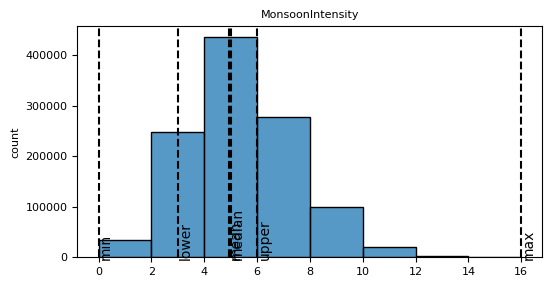

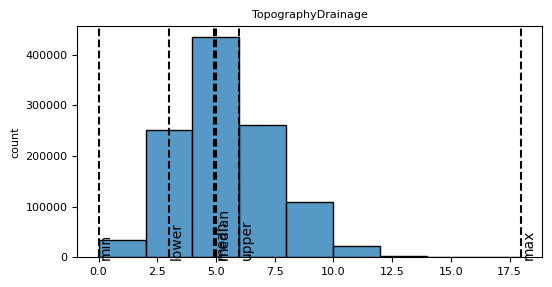

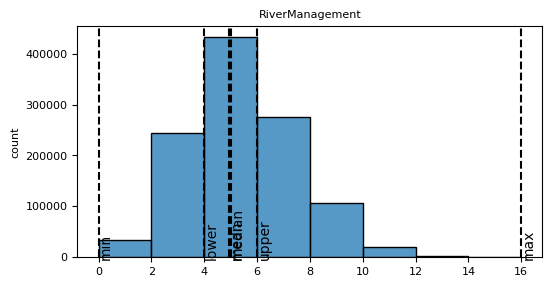

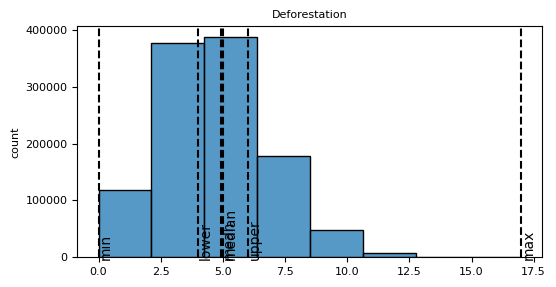

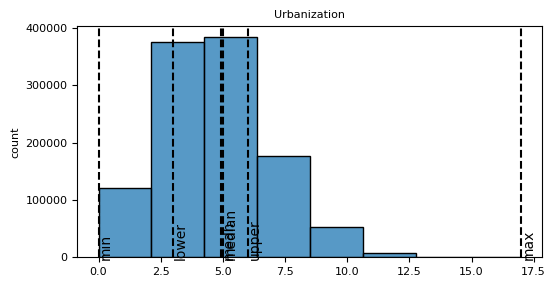

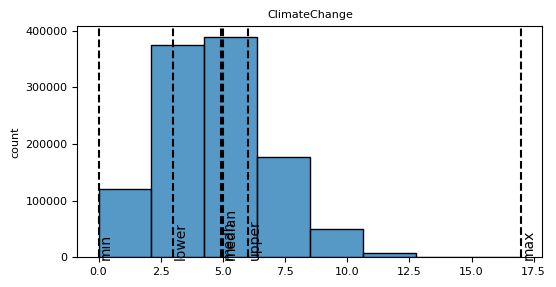

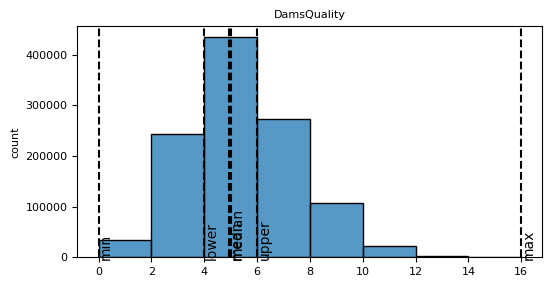

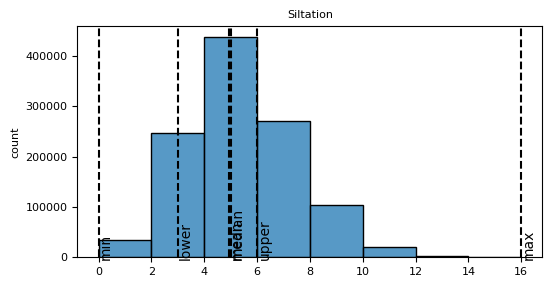

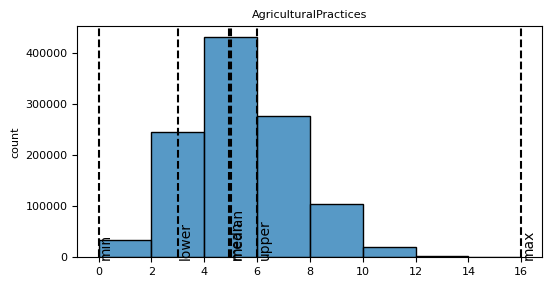

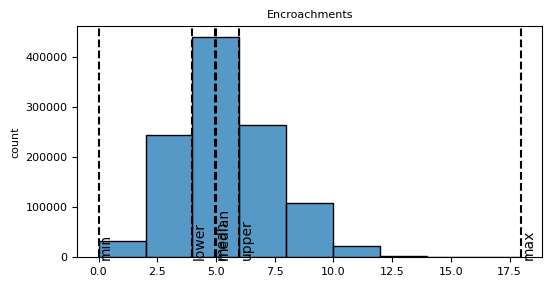

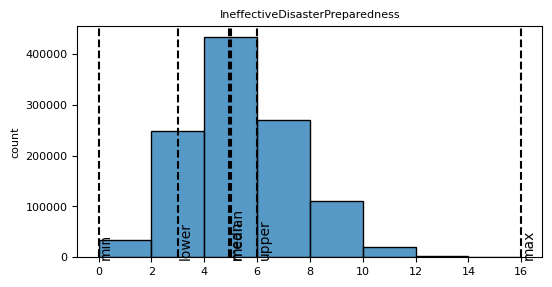

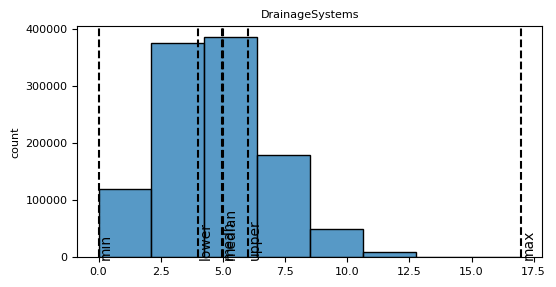

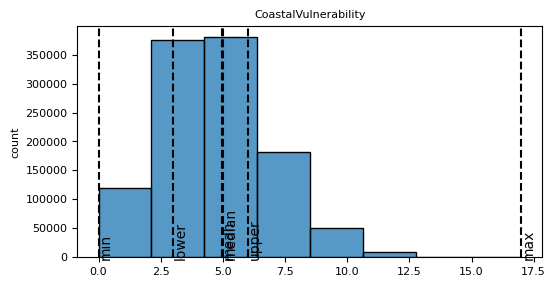

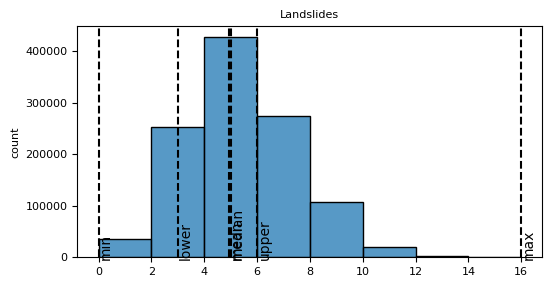

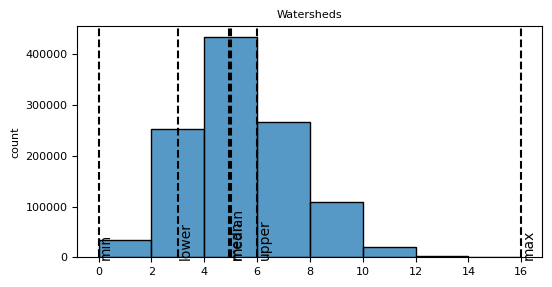

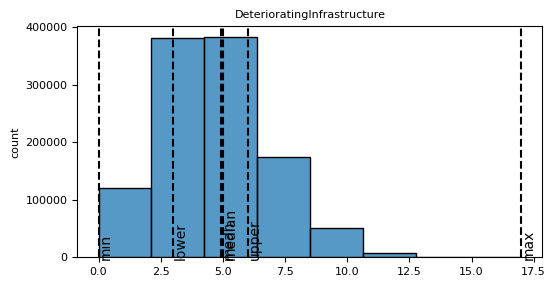

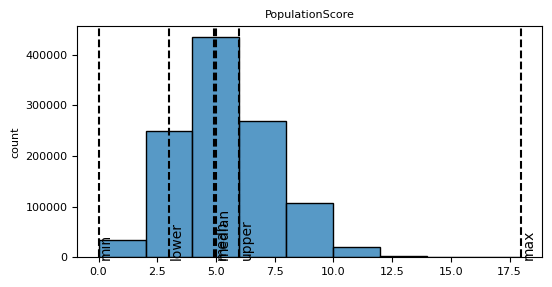

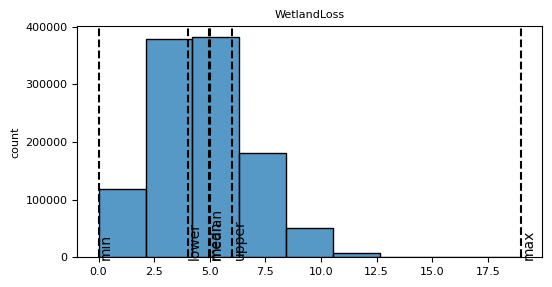

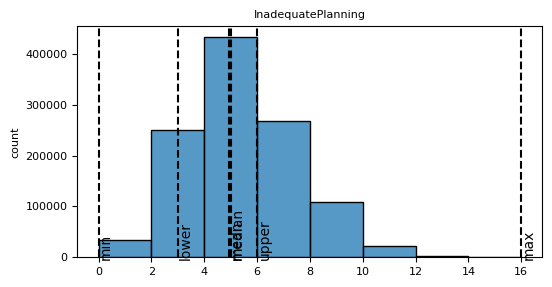

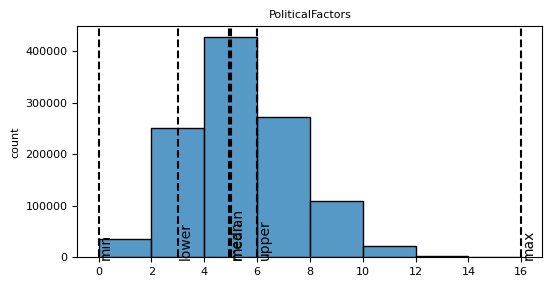

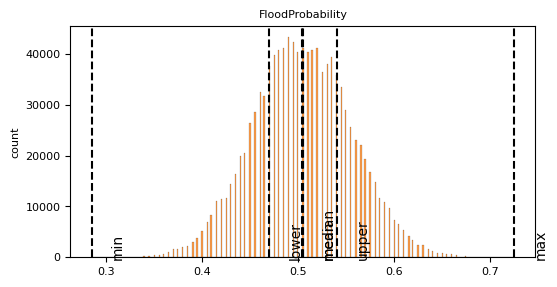

In [9]:
for i in train_df.columns:
    if train_df[i].nunique() == len(train_df):
        pass 
    else:
        plot_distribution(df=train_df, variable=i)

<u> Notes: </u>

1. Seems like most of the independent variables share similar mean and median values and are spread out relatively equally around the mean / median, i.e. bell-shaped distributions
2. There are also some outliers to the right (right skewed) but not extreme enough to pull the mean away from the center

---

<a id='bivariate1'></a>
### Bivariate analysis - between independent and target variable

In [10]:
def plot_correlation(
        df: pd.DataFrame,
        variable: str,
        text_ycoord: int = 0.7
):
    """
    Plot scatterplots for specified variable (x axis) against target variable (y axis) and 
    calculate Spearman's correlation coefficient

    """
    # prep table 
    target = 'FloodProbability'
    lowest = min(train_df['FloodProbability'])
    highest = max(train_df['FloodProbability'])
    plot_df = df.groupby(variable)[target].mean().to_frame().reset_index()

    # correlation 
    corr, pv = stats.spearmanr(df[variable], df[target])
    
    # plot 
    plt.figure(figsize=(6,3))
    sns.regplot(data=plot_df, x=variable, y=target)
    plt.title(f"Flood probability (mean) against {variable}", fontsize=8)
    plt.xlabel(f"{variable}", fontsize=8)
    plt.xticks(fontsize=8)
    plt.ylabel('Flood probability (mean)', fontsize=8)
    plt.yticks([round(i,2) for i in np.linspace(lowest, highest,10)], fontsize=8)
    plt.ylim(min(df[target]), max(df[target]))
    plt.text(max(df[variable]-2), text_ycoord, f"corr: {round(corr,2)}", color='black');
    

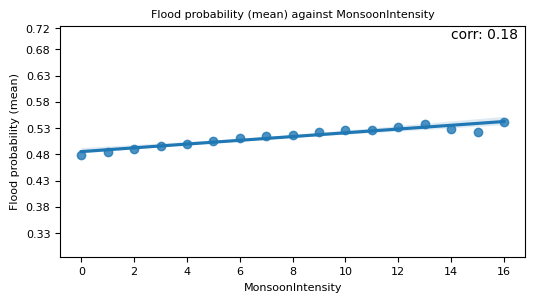

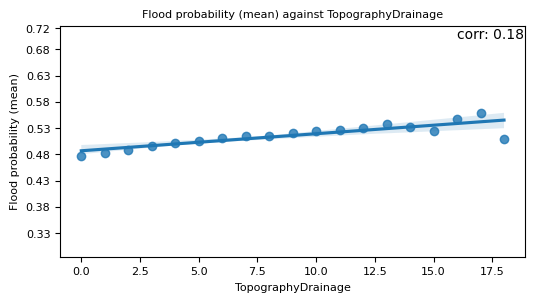

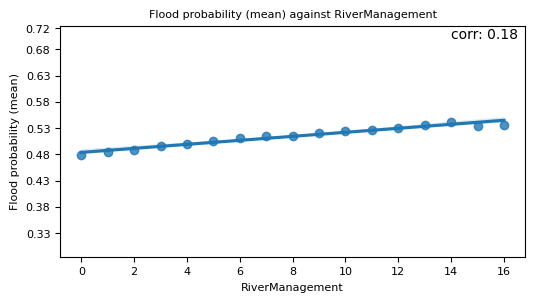

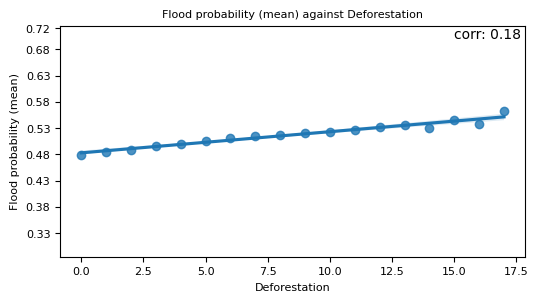

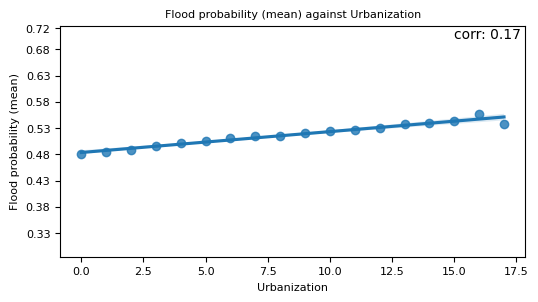

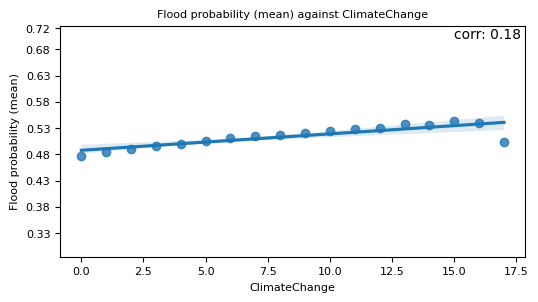

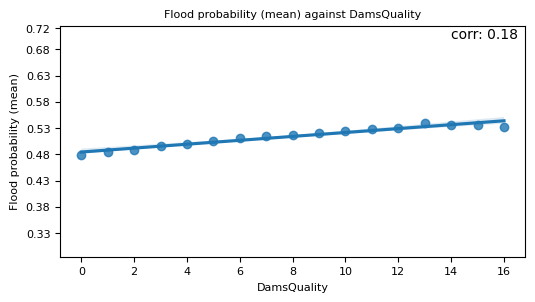

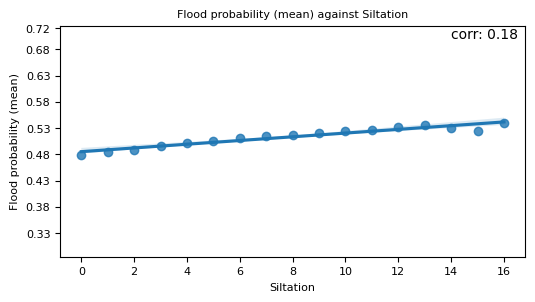

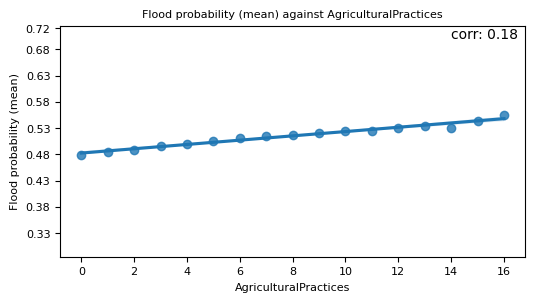

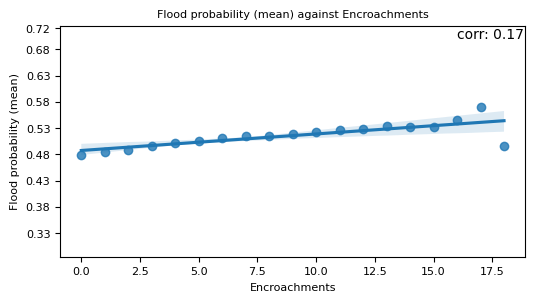

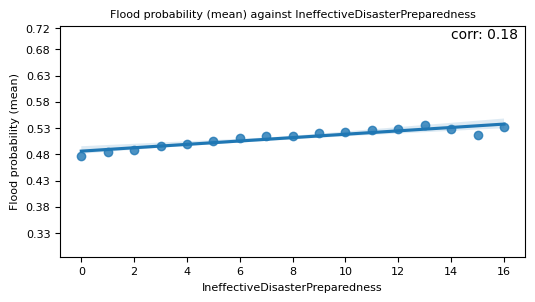

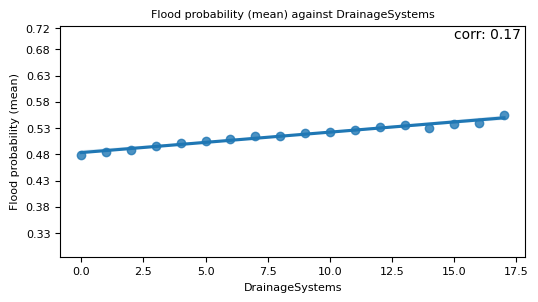

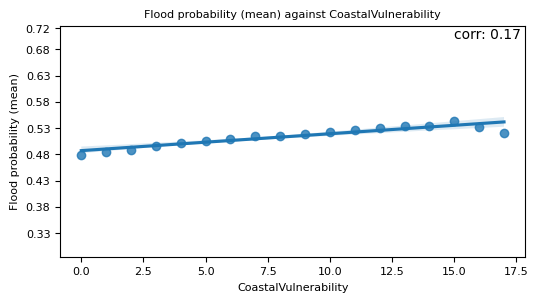

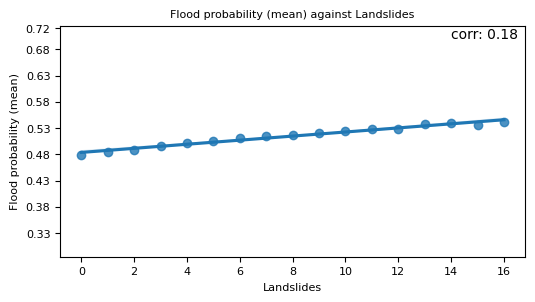

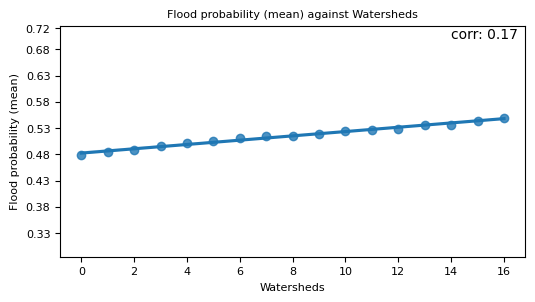

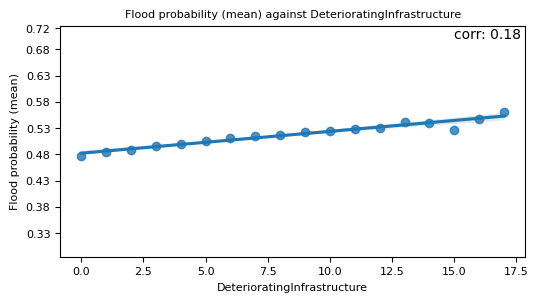

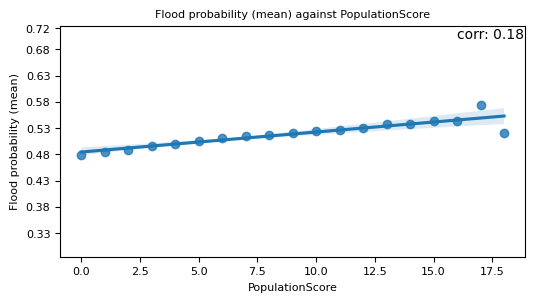

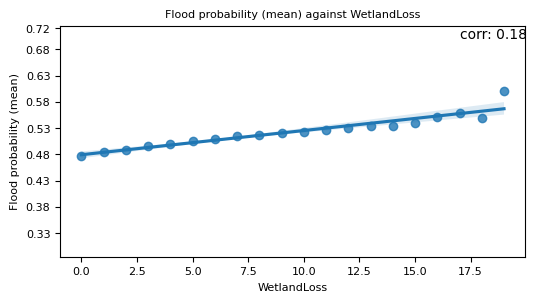

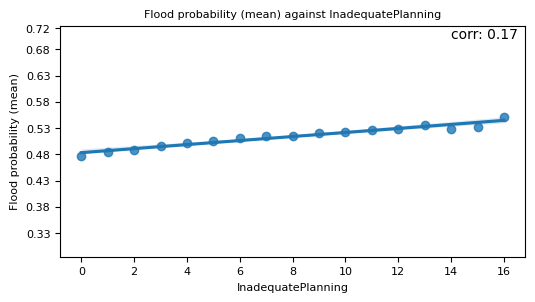

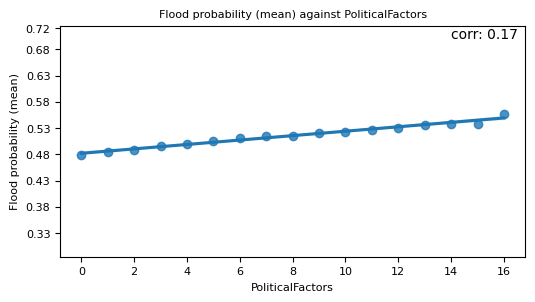

In [11]:
for i in train_df.columns:
    if i in ('id','FloodProbability'):
        pass 
    else:
        plot_correlation(df=train_df, text_ycoord=0.7, variable=i)

<u> Notes: </u>

1. Seems like the strength of relationship between each independent and target variable are similar, at about + 0.17 / + 0.18
2. Correlations are quite poor for all pairings, at least when average flood probabilities is used

In [12]:
def plot_boxplots(
        df: pd.DataFrame,
        target: str,
        variable: str
):
    """
    Plot boxplots for specified variable (x axis) against target variable (y axis)

    """
    # prep table 
    lowest = min(train_df[target])
    highest = max(train_df[target])
    
    # plot 
    plt.figure(figsize=(6,3))
    sns.boxplot(data=df, x=variable, y=target)
    plt.title(f"Distribution of {target} against {variable}", fontsize=8)
    plt.xlabel(f"{variable}", fontsize=8)
    plt.xticks(fontsize=8)
    plt.ylabel(f"{target}", fontsize=8)
    plt.yticks([round(i,2) for i in np.linspace(lowest, highest, 10)], fontsize=8)
    plt.ylim(min(df[target]-0.05), max(df[target])+0.05);

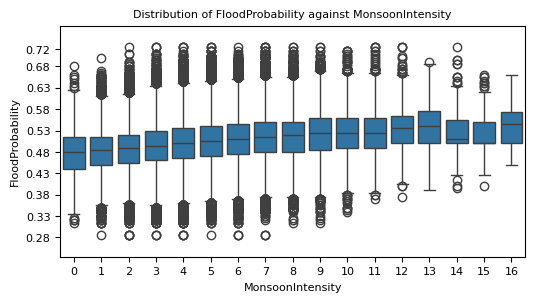

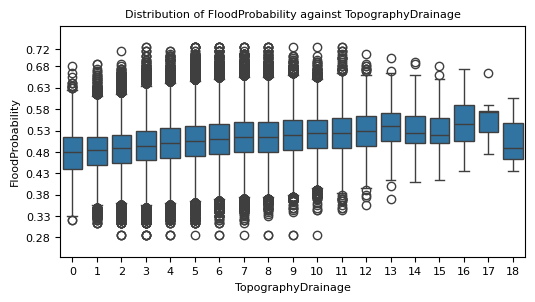

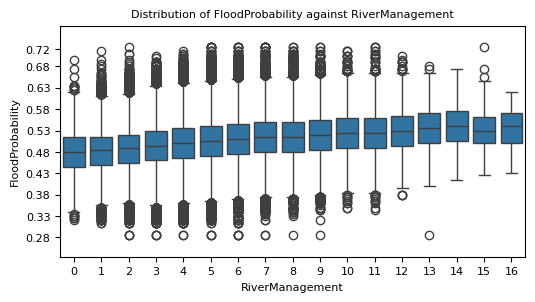

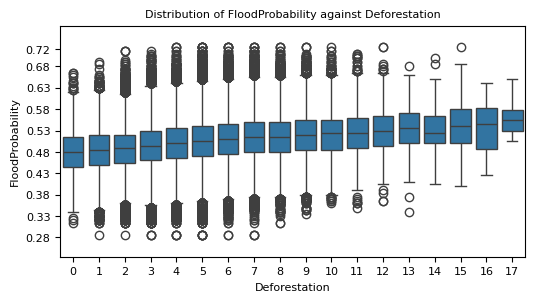

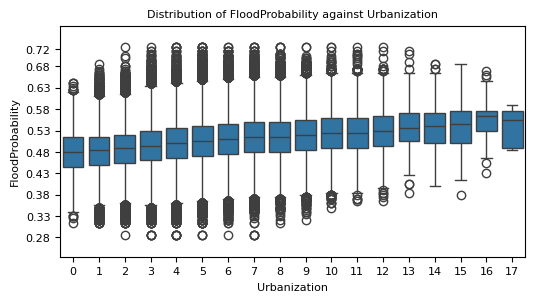

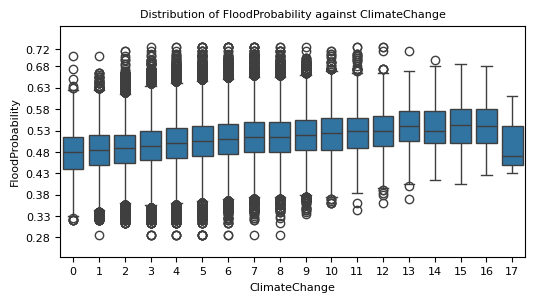

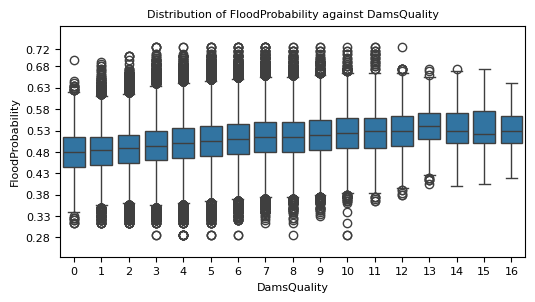

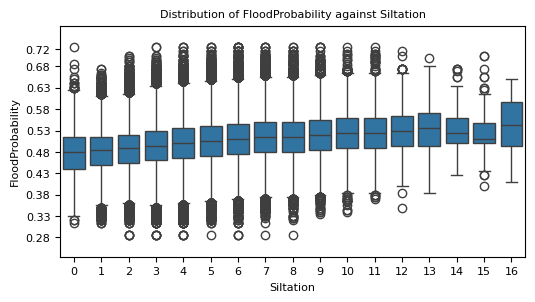

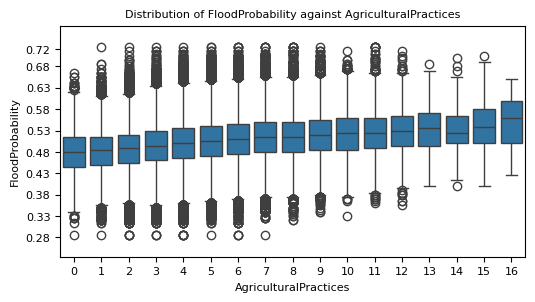

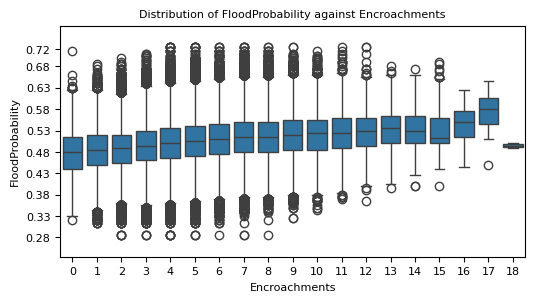

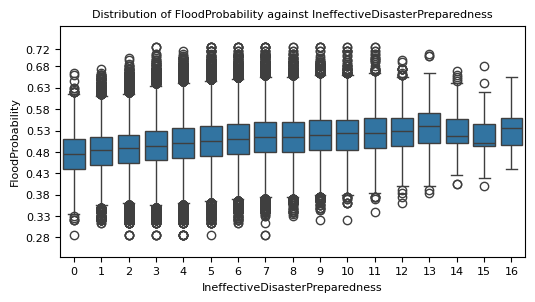

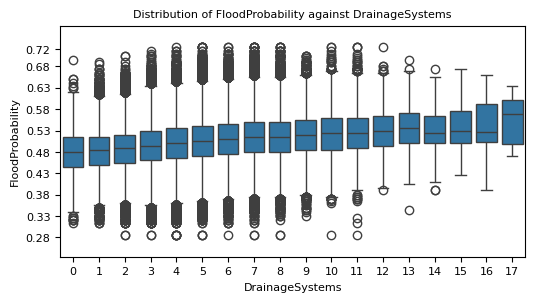

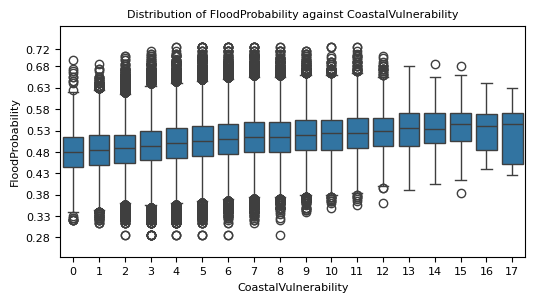

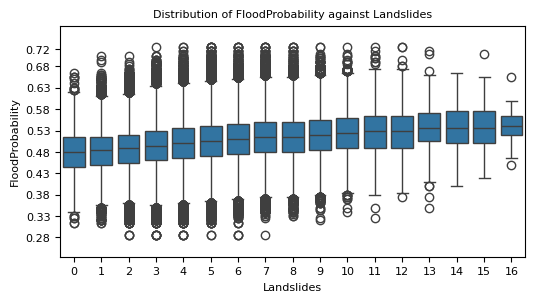

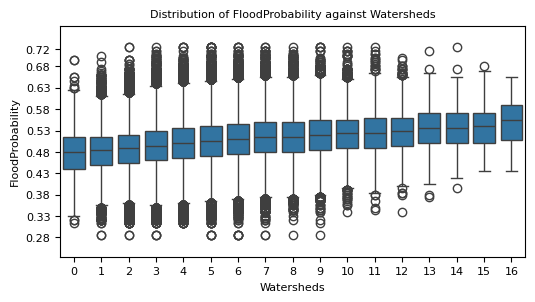

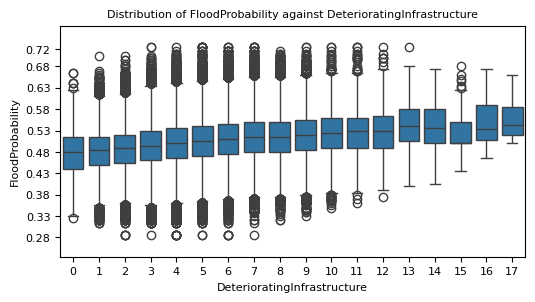

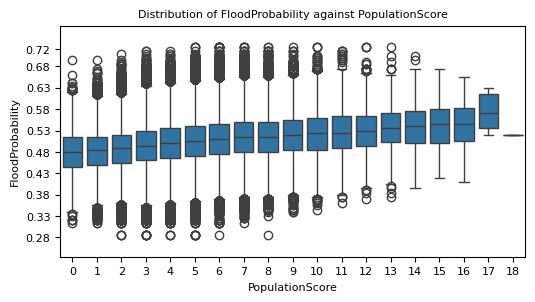

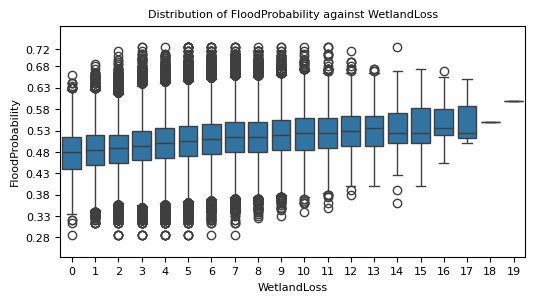

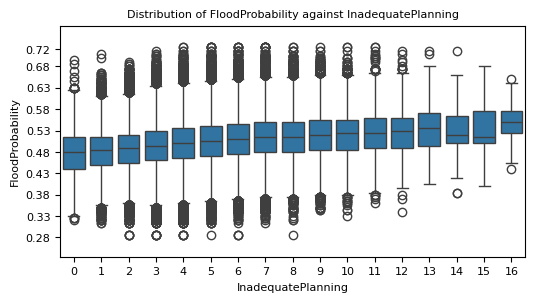

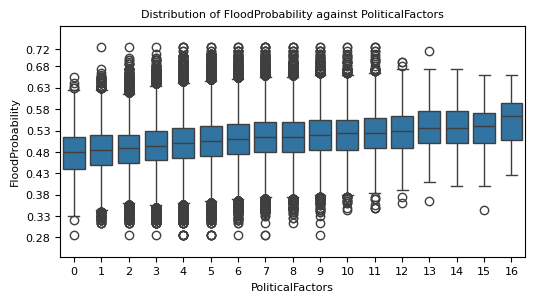

In [13]:
for i in train_df.columns:
    if i in ('id','FloodProbability'):
        pass 
    else:
        plot_boxplots(df=train_df, target='FloodProbability', variable=i)

<u> Notes: </u>

1. There are many outlier flood probabilities across the mid-values of the independent variables
2. Less outliers are found among higher values, but is probably due to low sample size
3. We still see a similar trend of a poorish correlation between the independent variables and median flood probabilities

---

<a id='bivariate2'></a>
### Bivariate analysis - between independent variables

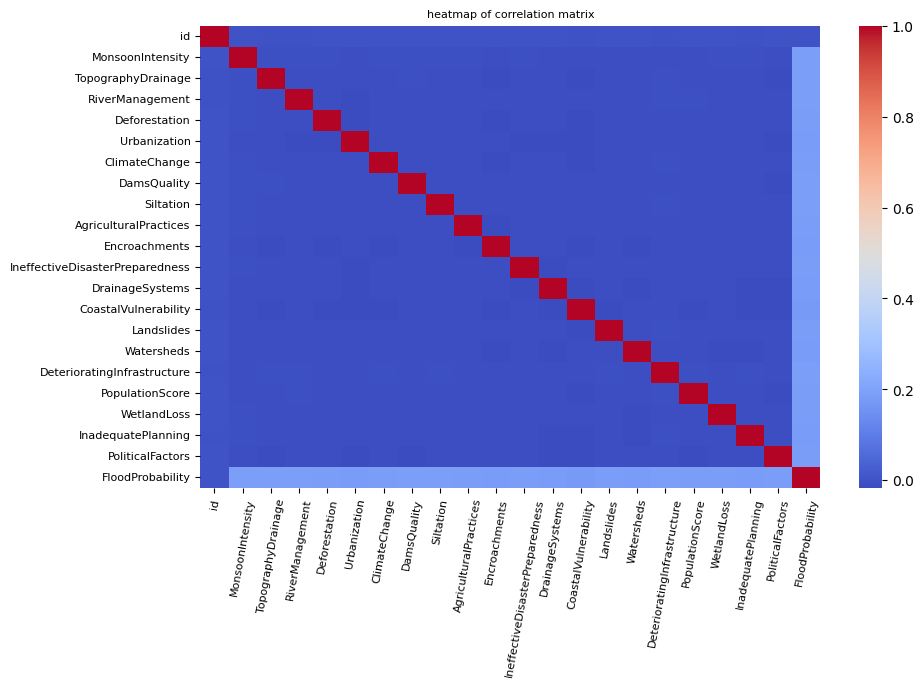

In [14]:
# correlation
corr = train_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('heatmap of correlation matrix', fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=80);

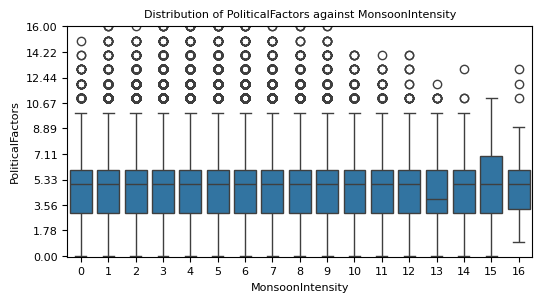

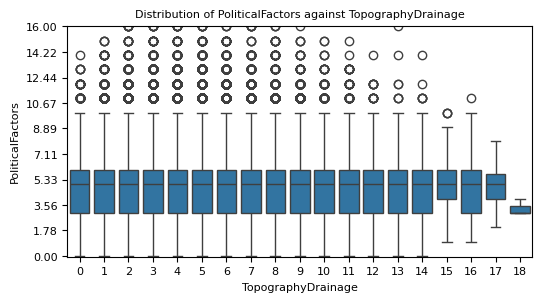

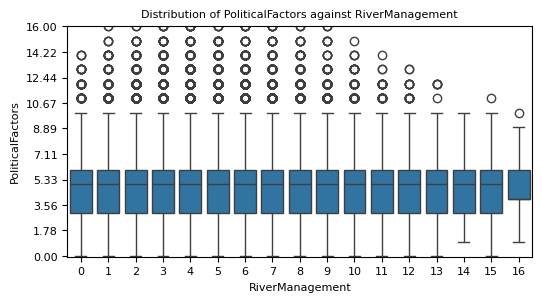

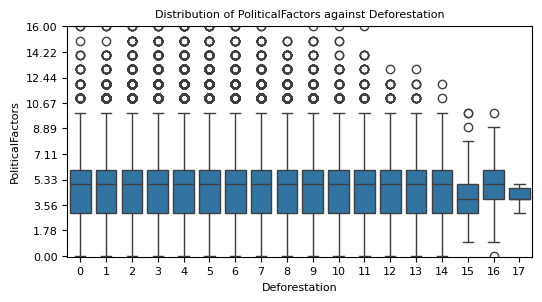

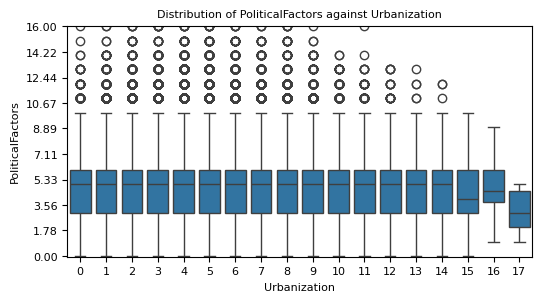

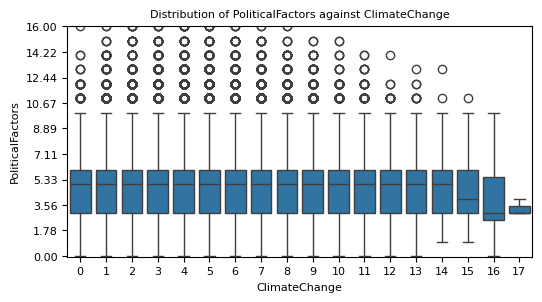

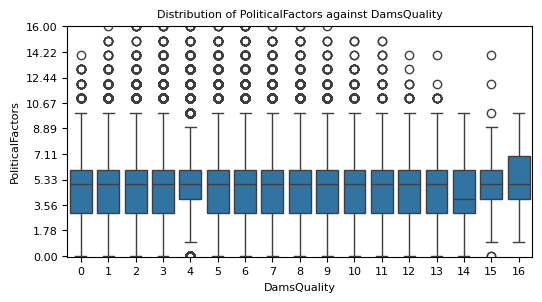

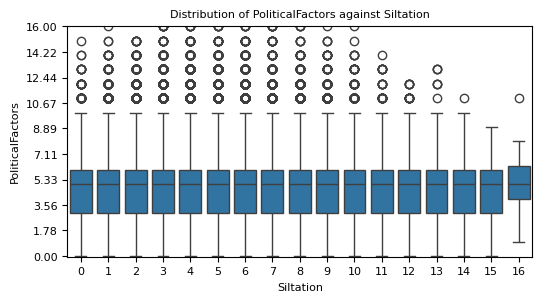

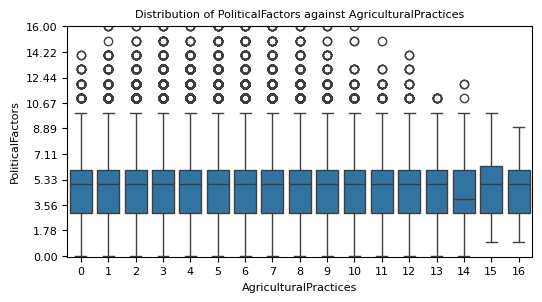

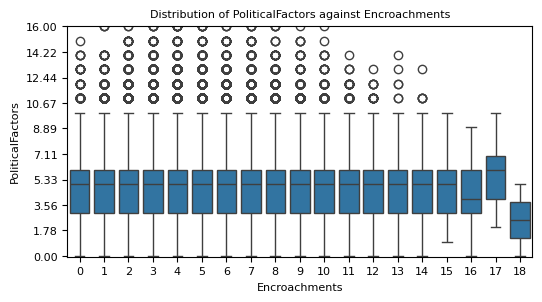

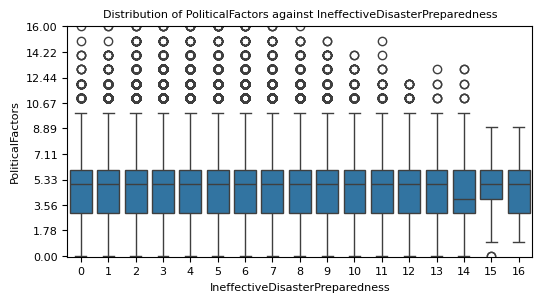

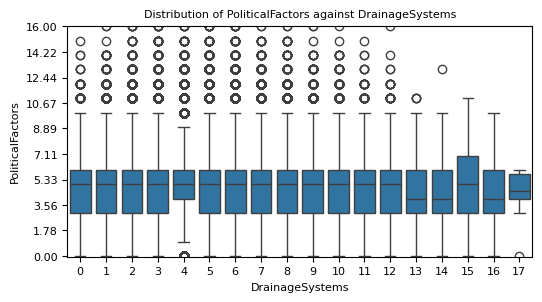

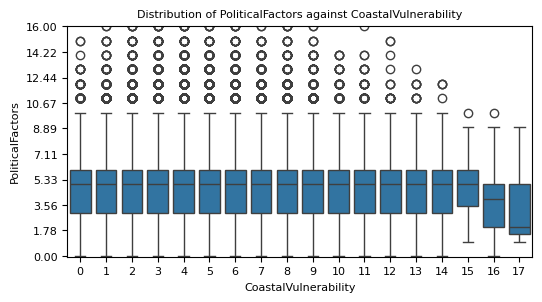

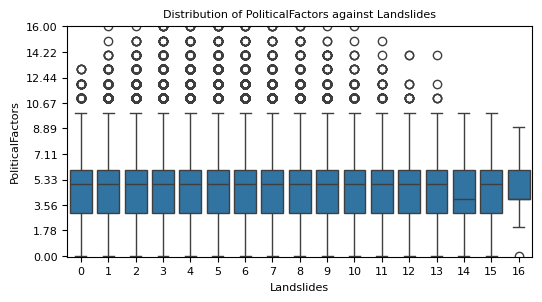

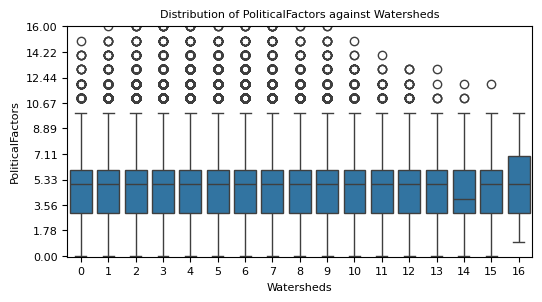

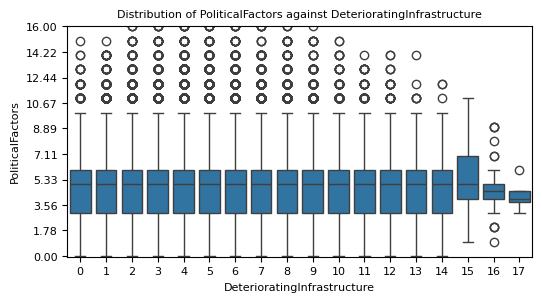

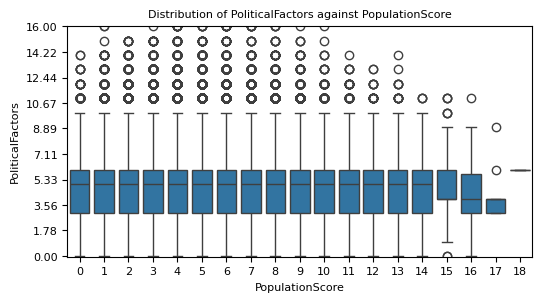

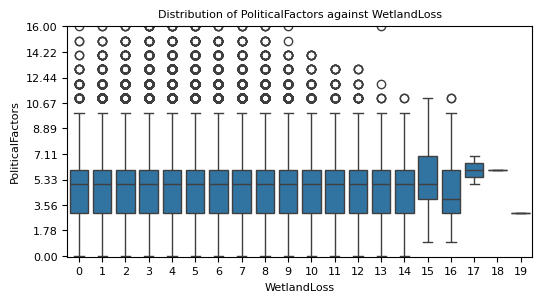

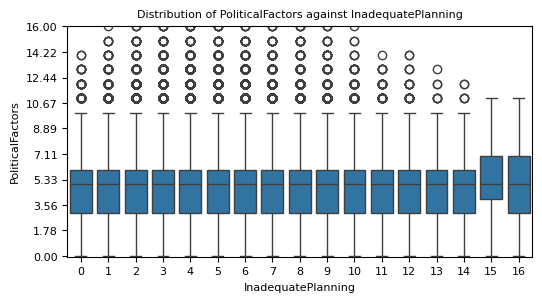

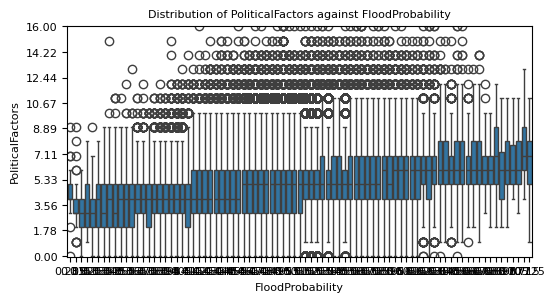

In [15]:
# test for another target variable to verify above
for i in train_df.columns:
    if i in ('id','PoliticalFactors'):
        pass 
    else:
        plot_boxplots(df=train_df, target='PoliticalFactors', variable=i)

<u> Notes: </u>

1. There doesn't seem to be correlations between any of the independent variables, except for correlations between each independent variable and the target variable

---

<a id='pca'></a>
### PCA

In [16]:
# pca
X = train_df.columns.tolist()
X.remove('id')
X.remove('FloodProbability')

pca = PCA()

X_pca = pca.fit_transform(train_df[X])

# variance of data explained by principal components
explained_variance_ratio = pca.explained_variance_ratio_

# eigenvectors
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(train_df[X].shape[1])], 
                        index=X)

sorted_loadings = loadings.abs().sort_values(by='PC1', ascending=False)

In [17]:
explained_variance_ratio

array([0.05154727, 0.05151653, 0.05131702, 0.05107014, 0.05102997,
       0.05098338, 0.0508381 , 0.05077164, 0.05069371, 0.05056218,
       0.05051043, 0.0503371 , 0.05025168, 0.05017571, 0.05004197,
       0.04985149, 0.04968824, 0.04946495, 0.04932201, 0.04002649])

In [18]:
k = 5  
top_features_pc1 = sorted_loadings.index.tolist()[:k]
print(f"Top {k} features for PC1:")
print(top_features_pc1)

Top 5 features for PC1:
['TopographyDrainage', 'PoliticalFactors', 'CoastalVulnerability', 'DamsQuality', 'IneffectiveDisasterPreparedness']


In [19]:
sorted_loadings

PC1       PC2       PC3       PC4  \
TopographyDrainage               0.745429  0.095871  0.523446  0.220574   
PoliticalFactors                 0.555547  0.185714  0.712189  0.025506   
CoastalVulnerability             0.230425  0.826230  0.128941  0.321190   
DamsQuality                      0.220311  0.025282  0.137111  0.363951   
IneffectiveDisasterPreparedness  0.089880  0.138938  0.011145  0.004469   
Encroachments                    0.086519  0.387504  0.277965  0.329263   
Urbanization                     0.078283  0.221243  0.234278  0.373780   
InadequatePlanning               0.054308  0.151501  0.110899  0.047200   
Siltation                        0.048973  0.043076  0.008951  0.029638   
DrainageSystems                  0.046024  0.025909  0.002868  0.008499   
ClimateChange                    0.032122  0.018698  0.009540  0.075782   
DeterioratingInfrastructure      0.028322  0.005333  0.019351  0.000286   
PopulationScore                  0.028267  0.080683  0.161923  0.136135   
Watersheds                       0.023641  0.103007  0.025645  0.649419   
RiverManagement                  0.023390  0.007499  0.071306  0.091359   
AgriculturalPractices            0.020458  0.020518  0.028725  0.059607   
Landslides                       0.018224  0.098635  0.020228  0.004114   
Deforestation                    0.013067  0.009472  0.051552  0.042461   
WetlandLoss                      0.012294  0.034744  0.045321  0.059199   
MonsoonIntensity                 0.010042  0.011503  0.018214  0.022439   

                                      PC5       PC6       PC7       PC8  \
TopographyDrainage               0.027372  0.051205  0.178215  0.032090   
PoliticalFactors                 0.111839  0.007020  0.037918  0.132181   
CoastalVulnerability             0.053390  0.041629  0.122629  0.021470   
DamsQuality                      0.063883  0.278899  0.394360  0.580762   
IneffectiveDisasterPreparedness  0.038471  0.170532  0.370588  0.060119   
Encroachments                    0.181507  0.618766  0.365984  0.013316   
Urbanization                     0.536812  0.561951  0.219981  0.089410   
InadequatePlanning               0.568856  0.390863  0.339361  0.390871   
Siltation                        0.029842  0.036184  0.009071  0.013934   
DrainageSystems                  0.007080  0.096515  0.048450  0.071911   
ClimateChange                    0.033905  0.019239  0.039087  0.028734   
DeterioratingInfrastructure      0.132055  0.032044  0.032217  0.142291   
PopulationScore                  0.176567  0.034265  0.070479  0.285222   
Watersheds                       0.437229  0.134252  0.420593  0.147023   
RiverManagement                  0.241181  0.012799  0.043143  0.168617   
AgriculturalPractices            0.015665  0.063127  0.018561  0.008703   
Landslides                       0.163100  0.017625  0.412134  0.549840   
Deforestation                    0.042993  0.007738  0.048612  0.007055   
WetlandLoss                      0.065612  0.034371  0.004631  0.130325   
MonsoonIntensity                 0.024068  0.019395  0.010039  0.043774   

                                      PC9      PC10      PC11      PC12  \
TopographyDrainage               0.070089  0.121235  0.016733  0.023881   
PoliticalFactors                 0.169152  0.125925  0.050950  0.041768   
CoastalVulnerability             0.170868  0.126320  0.094934  0.020058   
DamsQuality                      0.299234  0.229751  0.119342  0.050292   
IneffectiveDisasterPreparedness  0.799739  0.064662  0.226210  0.105707   
Encroachments                    0.064042  0.143079  0.106557  0.019236   
Urbanization                     0.028164  0.068908  0.086022  0.040431   
InadequatePlanning               0.158493  0.054210  0.278693  0.105584   
Siltation                        0.052610  0.023299  0.041899  0.064449   
DrainageSystems                  0.236264  0.838444  0.086729  0.183181   
ClimateChange                    0.054045  0.112499  0.020920

<u> Notes: </u>

1. Seems like all the principal components contribute equally to the variance of the data
2. Nevertheless, the top 5 features of PC1 are `TopographyDrainage`, `PoliticalFactors`, `CoastalVulnerability`, `DamsQuality` and `IneffectiveDisasterPreparedness`

---

<a id='umap'></a>
### [UMAP](#https://umap-learn.readthedocs.io/en/latest/parameters.html)

- UMAP scales faster with bigger datasets than t-SNE, but having a million observations to run it by would still take hours
- To randomly sample n observations across multiple bins of the target variable for faster computation
- `n_neighbors`: Balances between local and global structuring, i.e. how close do we want the similarities to be 
- `min_dist`: Controls how tightly the lower-dimensional points are packed together
- `n_components`: Determines the reduced dimension space the higher-dimensional points are embedded / projected to 
- `metric`: How similarities are calculated

In [20]:
# to append
random_samples = []

# parameters
s = 5000
q = [0,25,50,75,100]

for i in q:
    if i < 100:
        # identify quartiles
        first = np.percentile(train_df['FloodProbability'], i)
        second = np.percentile(train_df['FloodProbability'], i+1)
        # filter 
        subset = train_df[(train_df['FloodProbability'] >= first) & (train_df['FloodProbability'] <= second)]
        # randomly select 
        rows = np.random.choice(subset.index, size=s, replace=False)
        random_samples.extend(rows)
    else:
        pass

assert len(random_samples) == s*(len(q)-1), "mismatched lengths"
assert len(set(random_samples)) == len(random_samples), "duplicate rows"


In [21]:
# filter according to randomly selected rows
random_train_df = train_df.loc[random_samples]

# define labels for continuous target variable for clustering assignment
def syn_labels(
        x: int,
        bins: list = [np.percentile(train_df['FloodProbability'],0),
                      np.percentile(train_df['FloodProbability'],25),
                      np.percentile(train_df['FloodProbability'],50),
                      np.percentile(train_df['FloodProbability'],75),
                      np.percentile(train_df['FloodProbability'],100)]
):
    # filter 
    if (x >= bins[0]) & (x < bins[1]):
        return 'low'
    elif (x >= bins[1]) & (x < bins[2]):
        return 'medium'
    elif (x >= bins[2]) & (x < bins[3]):
        return 'medium-high'
    elif (x >= bins[3]) & (x < bins[4]):
        return 'high'
    else:
        return 'none'

bins = [np.percentile(train_df['FloodProbability'], 0),
        np.percentile(train_df['FloodProbability'], 25),
        np.percentile(train_df['FloodProbability'], 50),
        np.percentile(train_df['FloodProbability'], 75),
        np.percentile(train_df['FloodProbability'], 100)]

# apply
random_train_df['FloodProbability_labels'] = random_train_df['FloodProbability'].apply(lambda x: syn_labels(x, bins=bins))
random_train_df.reset_index(drop=True, inplace=True)
    
# split 
random_train_df_y = random_train_df[['FloodProbability_labels']]
random_train_df_x = random_train_df.drop(columns=['id','FloodProbability_labels','FloodProbability'], axis=1)


In [22]:
random_train_df_y.head(5)

FloodProbability_labels
0                     low
1                     low
2                     low
3                     low
4                     low

In [23]:
random_train_df_x.head(5)

MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
0                 3                   5                2              4   
1                 6                   7                6              2   
2                 2                   6                1              4   
3                 4                   7                4              2   
4                 3                   5                3              7   

   Urbanization  ClimateChange  DamsQuality  Siltation  AgriculturalPractices  \
0             4              3            2          4                      3   
1             2              3            3          1                      6   
2             7              5            5          3                      5   
3             4              8            2          1                      4   
4             6              3            4          4                      2   

   Encroachments  IneffectiveDisasterPreparedness  DrainageSystems  \
0              5                                2                5   
1              1                                7                3   
2              4                                2                2   
3              4                                4                0   
4              4                                6                1   

   CoastalVulnerability  Landslides  Watersheds  DeterioratingInfrastructure  \
0                     5           5           1                            3   
1                     4           2           7                            6   
2                     4           4           6                            2   
3                     2           1          10                            4   
4                     5           2           2                            4   

   PopulationScore  WetlandLoss  InadequatePlanning  PoliticalFactors  
0                6            4                   5                 3  
1                3            3                   3                 1  
2                4            8                   2                 3  
3                7            0                   7                 5  
4                4            3                   4                 4

In [24]:
# umap
import umap 

# grid search
param_grid = {
    'n_neighbors': [5, 10, 15],
    'min_dist': [0.1, 0.4, 0.8],
    'n_components': [2],
    'metric': ['euclidean']
}

umap_est = umap.UMAP(random_state=1)
grid_search = GridSearchCV(estimator=umap_est, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(random_train_df_x)
best_params = grid_search.best_params_


/opt/anaconda3/envs/kaggle_flood/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/anaconda3/envs/kaggle_flood/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/kaggle_flood/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 980, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/opt/anaconda3/envs/kaggle_flood/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -

In [25]:
best_params

{'metric': 'euclidean', 'min_dist': 0.1, 'n_components': 2, 'n_neighbors': 5}

In [26]:
# fit with best params 
best_umap_est = umap.UMAP(**best_params)
X_umap = best_umap_est.fit_transform(random_train_df_x)

# trustworthiness score 
tw_score = trustworthiness(random_train_df_x, X_umap, n_neighbors=5)
tw_score


0.7003398839535814

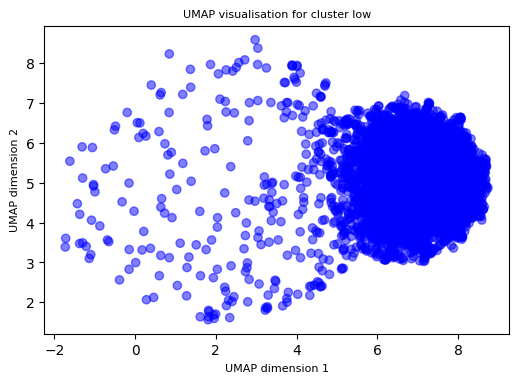

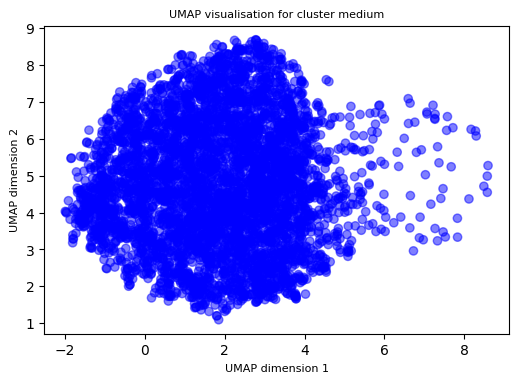

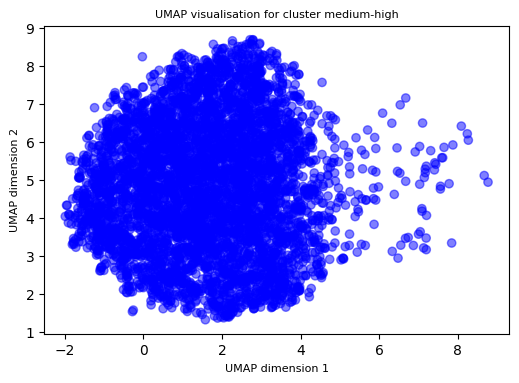

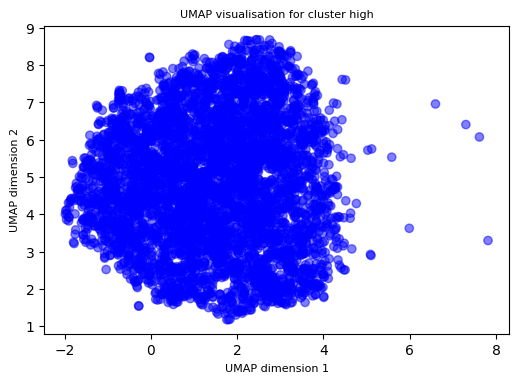

In [27]:
# map colors to target labels 
label_colors = {'low': 0, 'medium': 1, 'medium-high': 2, 'high': 3}
cmap = ListedColormap(['blue', 'cyan', 'magenta', 'red'])

# plot per cluster in case of overlaps 
for k,v in label_colors.items():
    # filter df to each probability label
    cluster_random_train_df_y = random_train_df_y[random_train_df_y['FloodProbability_labels']==k]
    # get index
    cluster_index = cluster_random_train_df_y.index.tolist()
    # use index to get correct UMAP coordinates
    X_umap_cluster_coord1 = X_umap[cluster_index, 0] 
    X_umap_cluster_coord2 = X_umap[cluster_index, 1] 
    # map colors 
    map_colors = cluster_random_train_df_y['FloodProbability_labels'].map(label_colors)
    # plot
    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(X_umap_cluster_coord1, X_umap_cluster_coord2, c=map_colors, cmap=cmap, alpha=0.5)
    # plt.colorbar(scatter, ticks=[0, 1, 2, 3], format=plt.FuncFormatter(lambda val, loc: ['low', 'medium', 'medium-high', 'high'][int(val)]))
    plt.title(f"UMAP visualisation for cluster {k}", fontsize=8)
    plt.xlabel('UMAP dimension 1', fontsize=8)
    plt.ylabel('UMAP dimension 2', fontsize=8)
    plt.show()
    

<u> Notes: </u>

1. There seems to be major overlaps in the medium, medium-high and high flood probability clusters (to the right).
2. Only the low cluster is separated from the rest (to the left).
3. Datapoints of the low cluster tend to have a narrower range of dimension 2's coordinates (y-axis) as compared with the other clusters.
4. Another observation also is its concentration of higher dimension 1's coordinates (x-axis). 
5. All these meaning to say that there are uniquely, distinctive properties to the low cluster, while the other clusters probably share more similar properties with each other. 

---

<a id='cluster'></a>
### Finding features that are unique to the low cluster

- Two-sample Z-test for means between the categorical clusters and each feature 
- Spearman's between UMAP dimension 1 coordinates and each feature (seeing as the low cluster has the highest concentration of the higher values of dimension 1)

In [28]:
train_df_copy = train_df.copy()

train_df_copy['FloodProbability_labels'] = train_df_copy['FloodProbability'].apply(lambda x: syn_labels(x, bins=bins))

train_df_copy['FloodProbability_labels'].value_counts()

FloodProbability_labels
high           291677
medium         285437
medium-high    277728
low            263086
none               29
Name: count, dtype: int64

In [29]:
train_df_copy.groupby('FloodProbability_labels')['FloodProbability'].min()

FloodProbability_labels
high           0.540
low            0.285
medium         0.470
medium-high    0.505
none           0.725
Name: FloodProbability, dtype: float64

In [30]:
train_df_copy.groupby('FloodProbability_labels')['FloodProbability'].max()

FloodProbability_labels
high           0.715
low            0.465
medium         0.500
medium-high    0.535
none           0.725
Name: FloodProbability, dtype: float64

In [31]:
# replace none
train_df_copy['FloodProbability_labels'] = train_df_copy['FloodProbability_labels'].replace('none','high')

train_df_copy['FloodProbability_labels'].value_counts()

FloodProbability_labels
high           291706
medium         285437
medium-high    277728
low            263086
Name: count, dtype: int64

In [32]:
# group non-low clusters together for simplicity 
train_df_copy['FloodProbability_labels'] = train_df_copy['FloodProbability_labels'].replace({
    'high':'non-low',
    'medium':'non-low',
    'medium-high':'non-low'})

train_df_copy['FloodProbability_labels'].value_counts()


FloodProbability_labels
non-low    854871
low        263086
Name: count, dtype: int64

In [33]:
# z-test
def z_test_for_means(
        df: pd.DataFrame, 
        target_cohort: str,
        cohort_1: str, 
        cohort_2: str, 
        continuous_feature: str
):
    """ 
    Calculate z-scores and p-values for distribution comparison of feature across cohort groups

    """
    # filter df by cohort
    sample_1 = df[df[target_cohort]==cohort_1][continuous_feature]
    sample_2 = df[df[target_cohort]==cohort_2][continuous_feature]

    # stats for z test
    mean_1 = np.mean(sample_1)
    mean_2 = np.mean(sample_2)
    std_1 = np.std(sample_1)
    std_2 = np.std(sample_2) 
    n_1 = len(sample_1)
    n_2 = len(sample_2)
    pooled_se = np.sqrt((std_1**2 / n_1) + (std_2**2 / n_2))

    # z-score 
    z_score = (mean_1 - mean_2) / pooled_se

    # p-value 
    p_value = 2 * stats.norm.sf(abs(z_score))

    # additional stats 
    median_1 = np.median(sample_1)
    median_2 = np.median(sample_2)

    print(f"{continuous_feature}")
    print(f"mean for cohort 1: {round(mean_1,0)}; cohort 2: {round(mean_2,0)}")
    print(f"median for cohort 1: {round(median_1,0)}; cohort 2: {round(median_2,0)} \n")

    return z_score, p_value


In [34]:
features = {'significant': {}, 'insignificant': {}}

for i in train_df_copy.columns:
    if i in ('id','FloodProbability','FloodProbability_labels'):
        pass 
    else:
        z, p = z_test_for_means(df=train_df_copy, 
                                target_cohort='FloodProbability_labels',
                                cohort_1='low',
                                cohort_2='non-low',
                                continuous_feature=i)
        # append results 
        if p < 0.05:
            features['significant'][i] = p 
        else: 
            features['insignificant'][i] = p


MonsoonIntensity
mean for cohort 1: 4.0; cohort 2: 5.0
median for cohort 1: 4.0; cohort 2: 5.0 

TopographyDrainage
mean for cohort 1: 4.0; cohort 2: 5.0
median for cohort 1: 4.0; cohort 2: 5.0 

RiverManagement
mean for cohort 1: 4.0; cohort 2: 5.0
median for cohort 1: 4.0; cohort 2: 5.0 

Deforestation
mean for cohort 1: 4.0; cohort 2: 5.0
median for cohort 1: 4.0; cohort 2: 5.0 

Urbanization
mean for cohort 1: 4.0; cohort 2: 5.0
median for cohort 1: 4.0; cohort 2: 5.0 

ClimateChange
mean for cohort 1: 4.0; cohort 2: 5.0
median for cohort 1: 4.0; cohort 2: 5.0 

DamsQuality
mean for cohort 1: 4.0; cohort 2: 5.0
median for cohort 1: 4.0; cohort 2: 5.0 

Siltation
mean for cohort 1: 4.0; cohort 2: 5.0
median for cohort 1: 4.0; cohort 2: 5.0 

AgriculturalPractices
mean for cohort 1: 4.0; cohort 2: 5.0
median for cohort 1: 4.0; cohort 2: 5.0 

Encroachments
mean for cohort 1: 4.0; cohort 2: 5.0
median for cohort 1: 4.0; cohort 2: 5.0 

IneffectiveDisasterPreparedness
mean for cohort 1

In [35]:
features

{'significant': {'MonsoonIntensity': 0.0,
  'TopographyDrainage': 0.0,
  'RiverManagement': 0.0,
  'Deforestation': 0.0,
  'Urbanization': 0.0,
  'ClimateChange': 0.0,
  'DamsQuality': 0.0,
  'Siltation': 0.0,
  'AgriculturalPractices': 0.0,
  'Encroachments': 0.0,
  'IneffectiveDisasterPreparedness': 0.0,
  'DrainageSystems': 0.0,
  'CoastalVulnerability': 0.0,
  'Landslides': 0.0,
  'Watersheds': 0.0,
  'DeterioratingInfrastructure': 0.0,
  'PopulationScore': 0.0,
  'WetlandLoss': 0.0,
  'InadequatePlanning': 0.0,
  'PoliticalFactors': 0.0},
 'insignificant': {}}

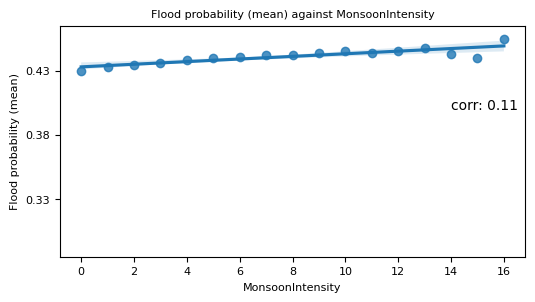

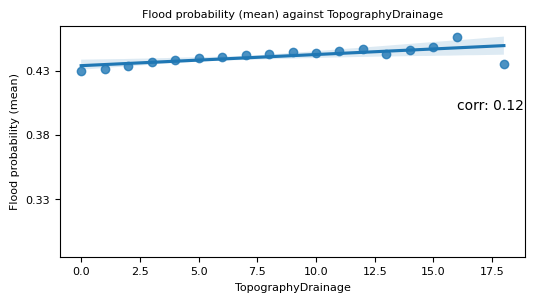

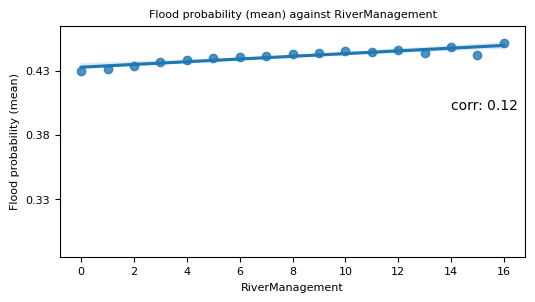

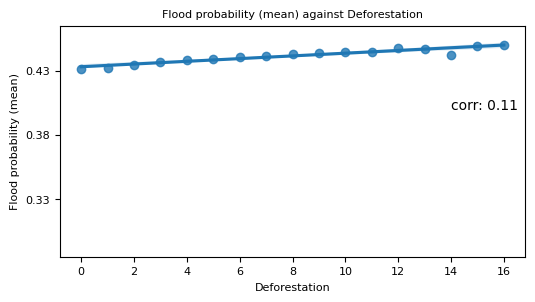

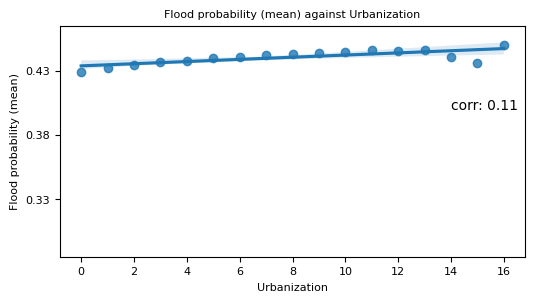

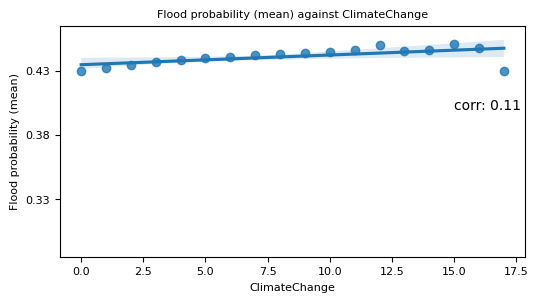

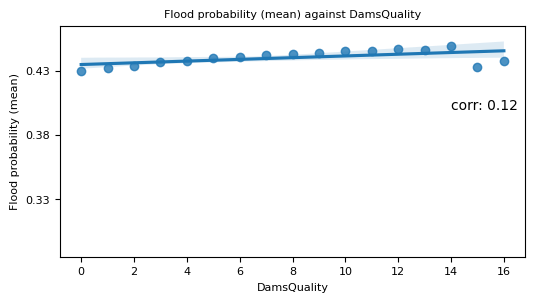

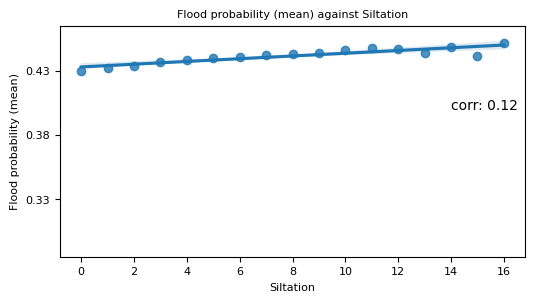

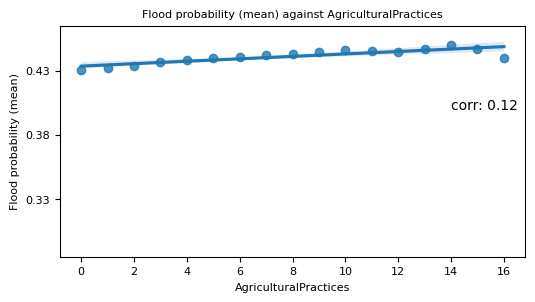

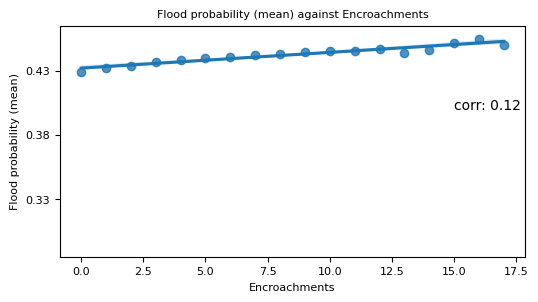

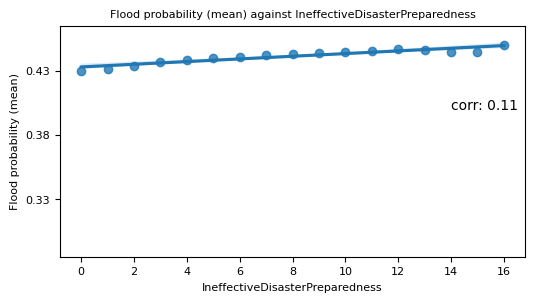

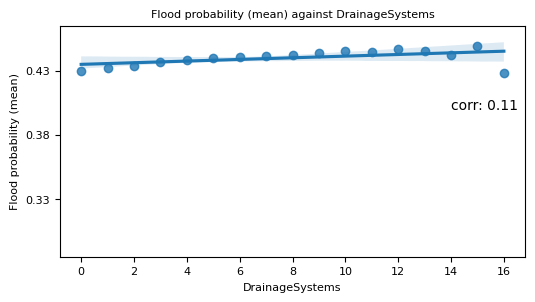

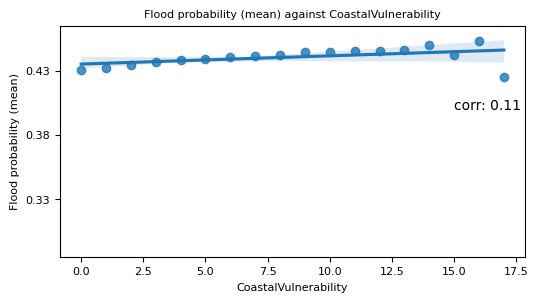

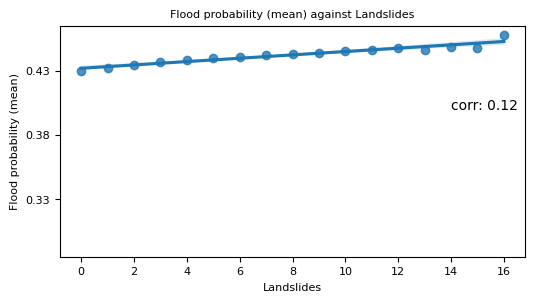

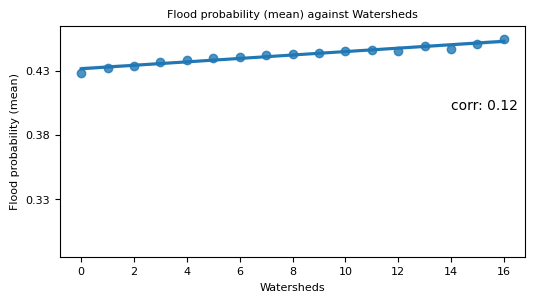

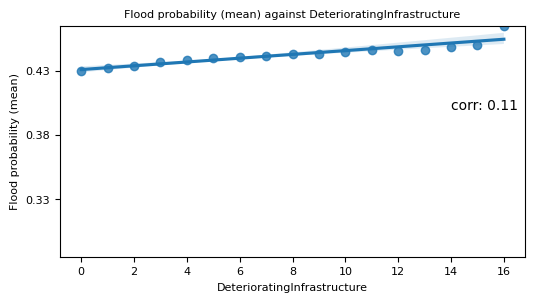

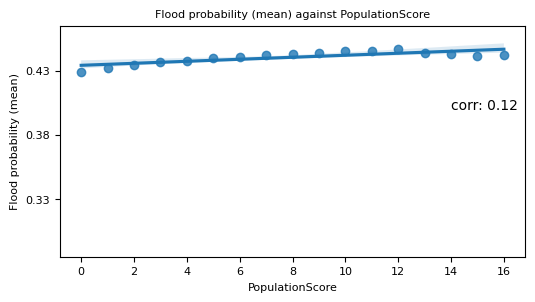

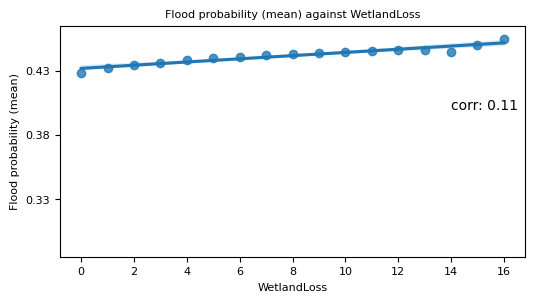

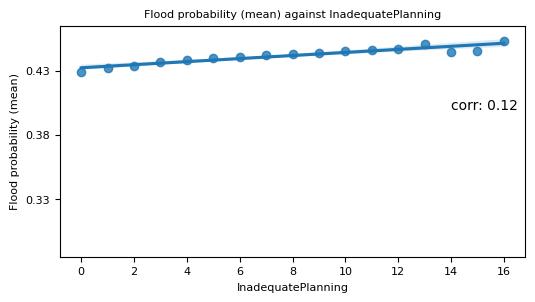

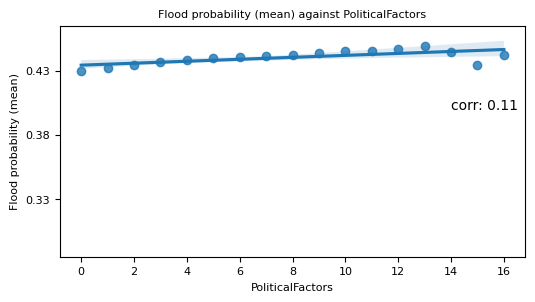

In [36]:
# spearmans for low cluster
for i in train_df_copy.columns:
    if i in ('id','FloodProbability','FloodProbability_labels'):
        pass 
    else:
        plot_correlation(df=train_df_copy[train_df_copy['FloodProbability_labels']=='low'],
                         text_ycoord=0.4, 
                         variable=i)

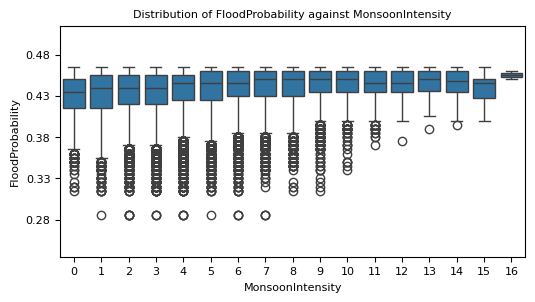

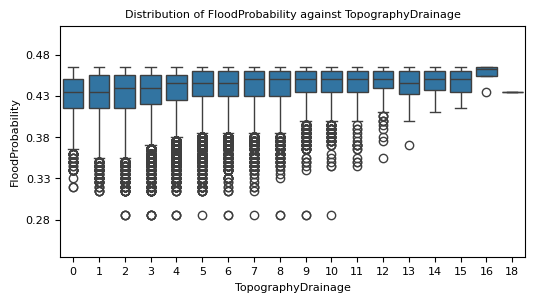

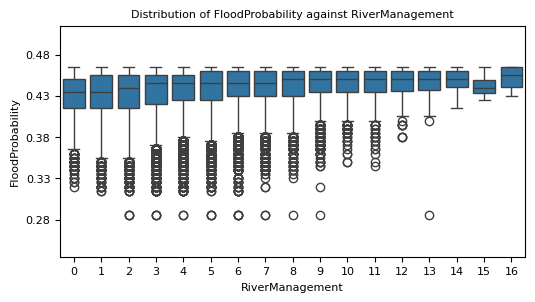

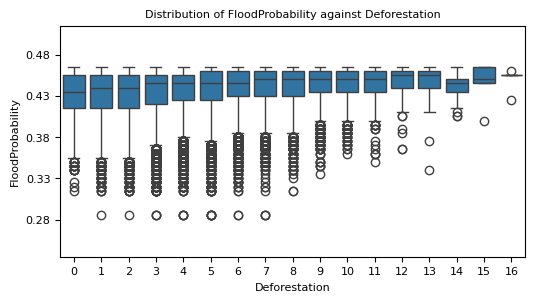

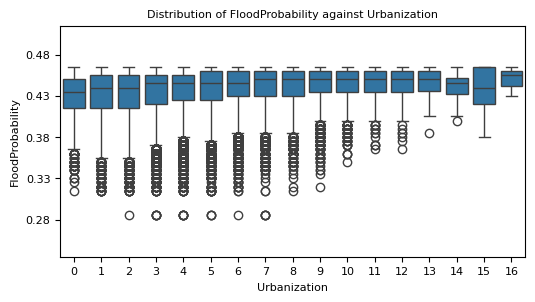

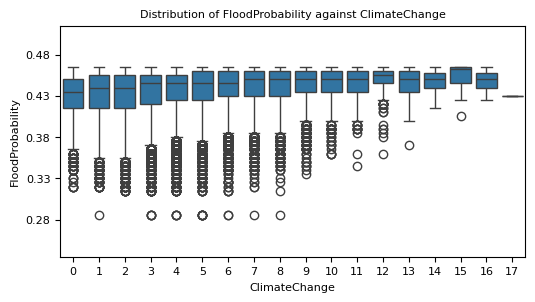

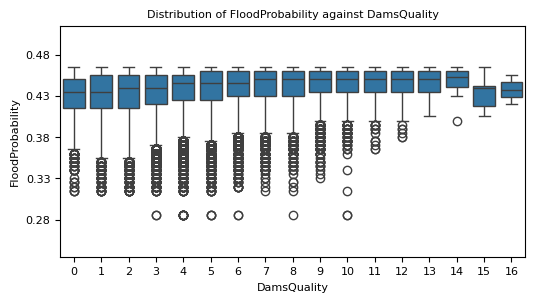

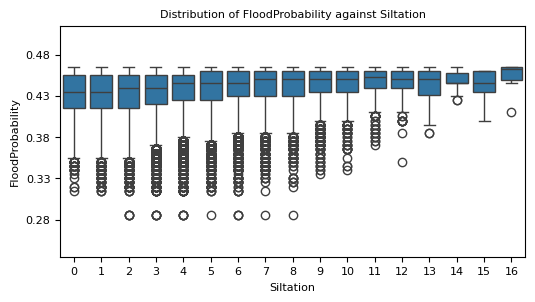

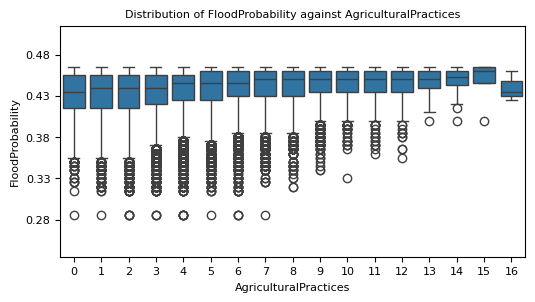

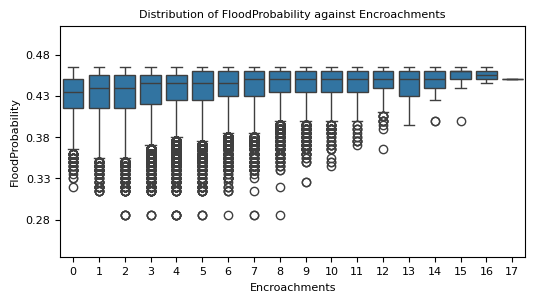

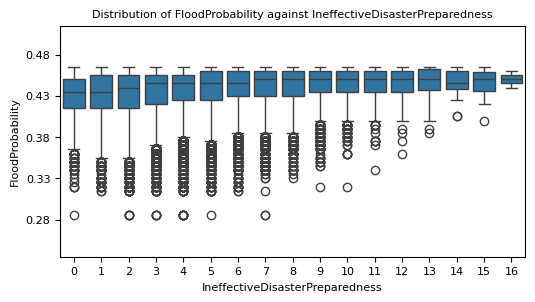

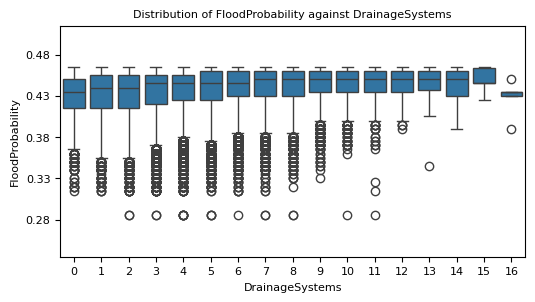

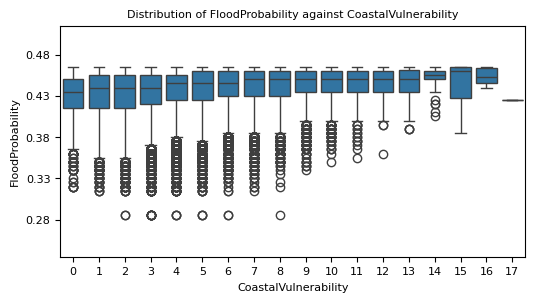

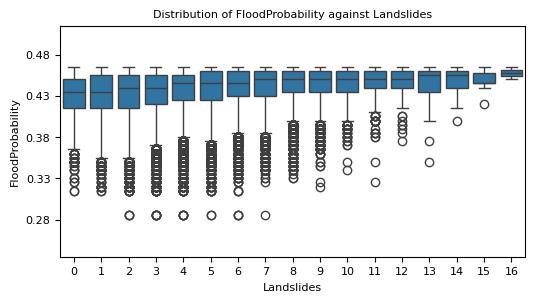

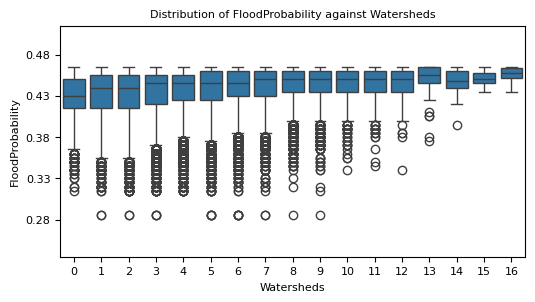

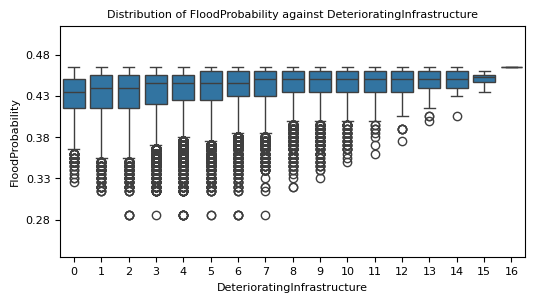

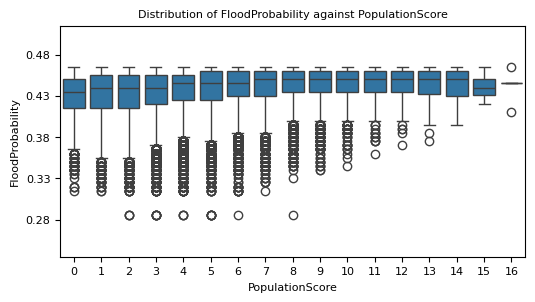

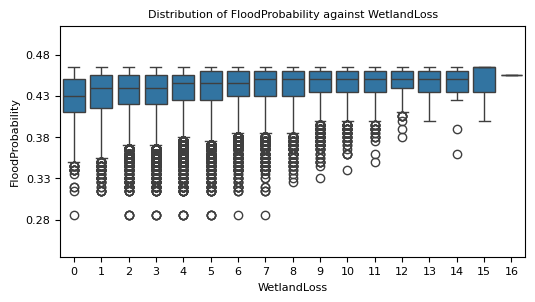

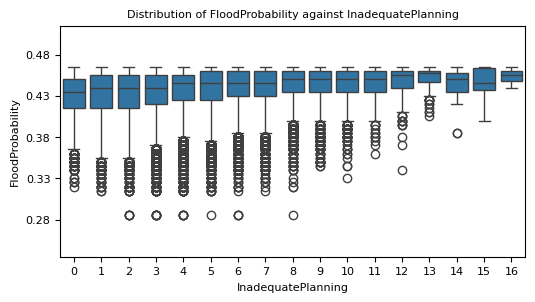

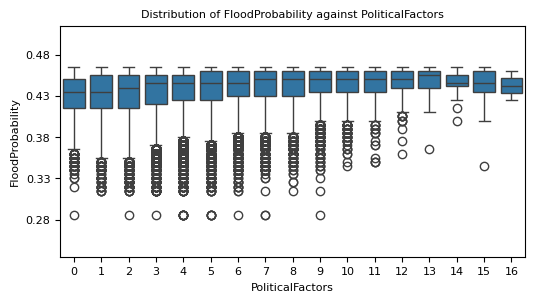

In [37]:
# boxplots for low cluster
for i in train_df_copy.columns:
    if i in ('id','FloodProbability','FloodProbability_labels'):
        pass 
    else:
        plot_boxplots(df=train_df_copy[train_df_copy['FloodProbability_labels']=='low'], 
                      target='FloodProbability',
                      variable=i)

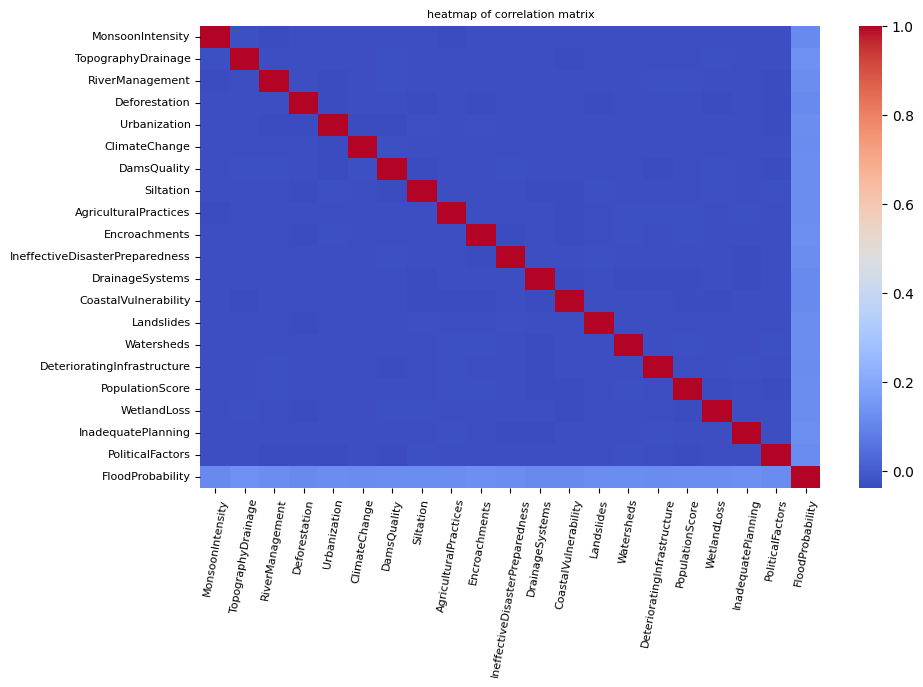

In [38]:
# correlation
corr = train_df_copy[train_df_copy['FloodProbability_labels']=='low'].drop(['id','FloodProbability_labels'], axis=1).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('heatmap of correlation matrix', fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=80);

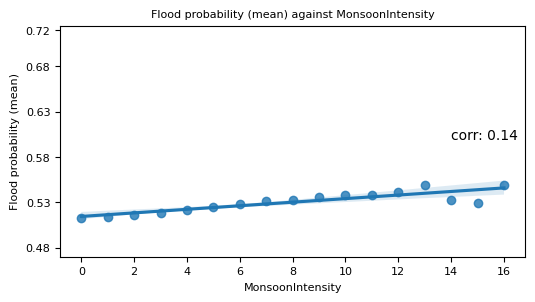

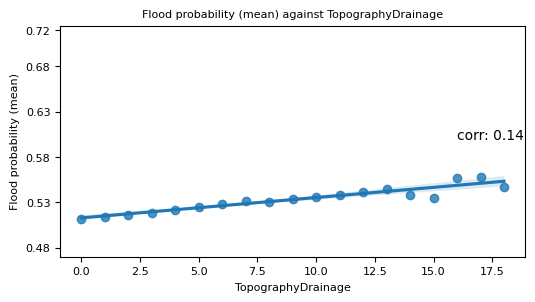

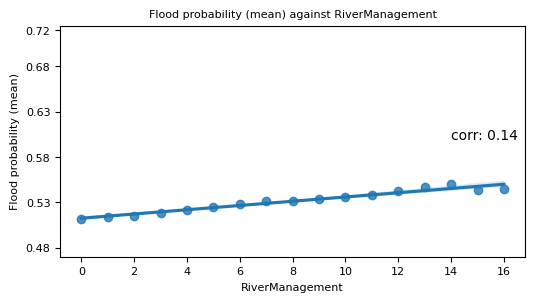

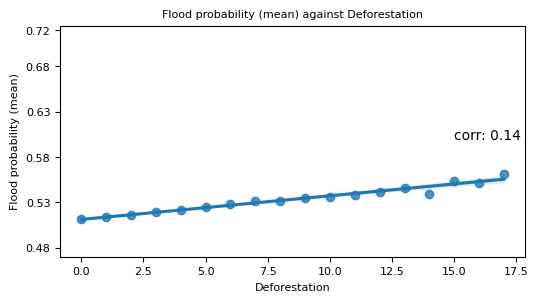

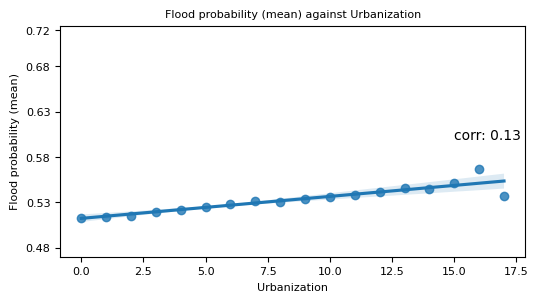

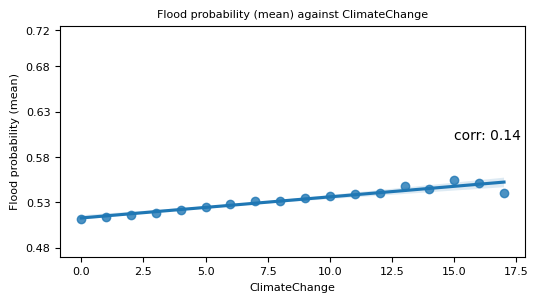

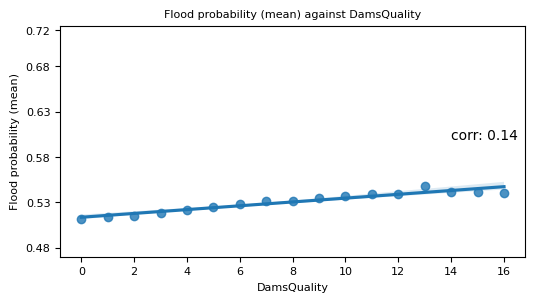

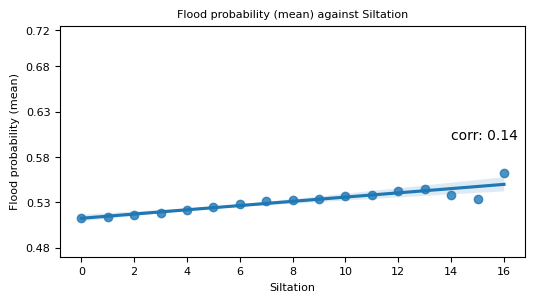

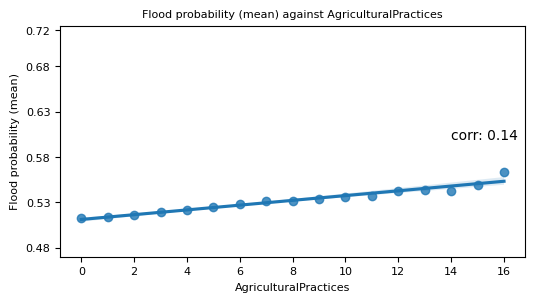

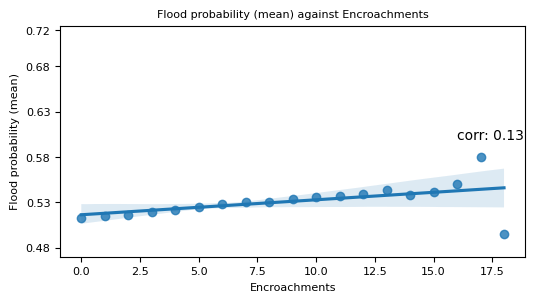

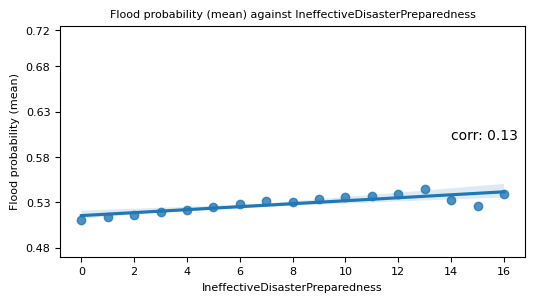

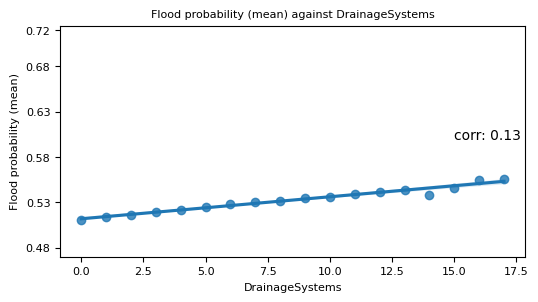

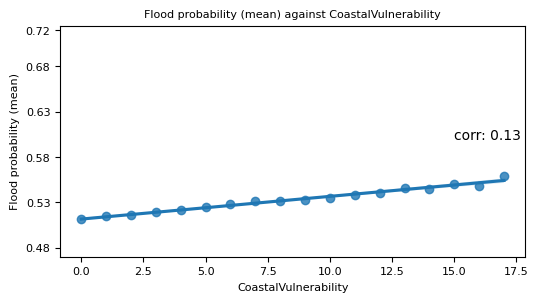

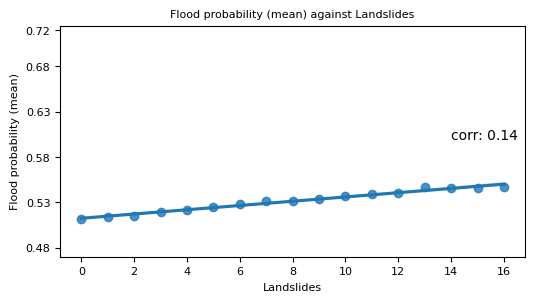

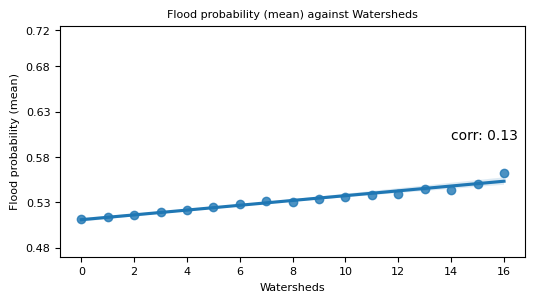

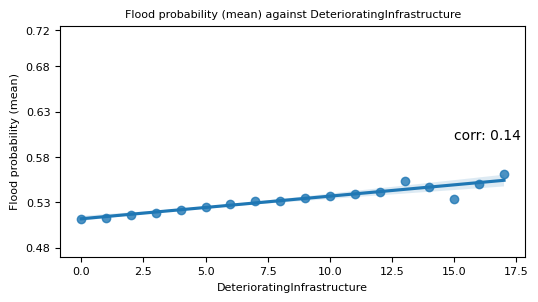

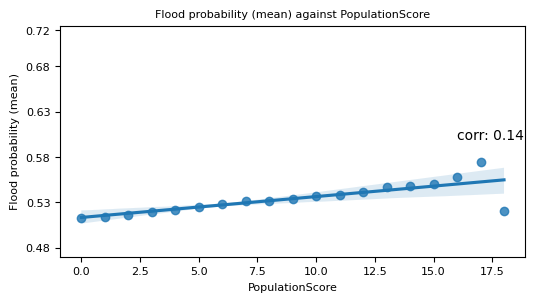

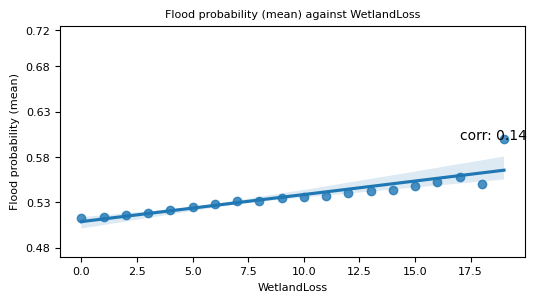

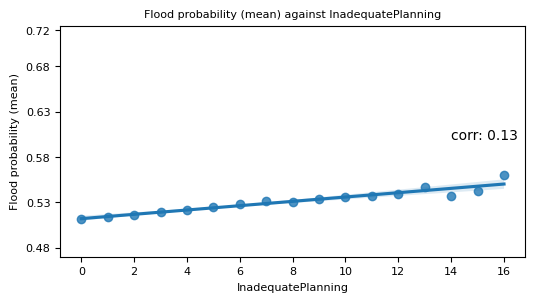

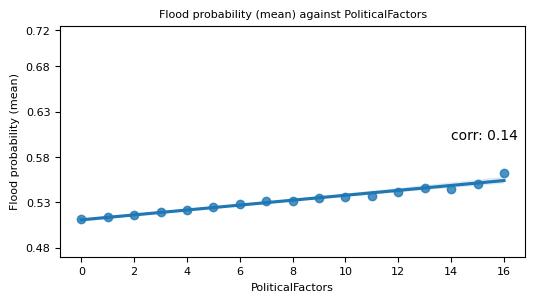

In [39]:
# spearmans for non-low cluster
for i in train_df_copy.columns:
    if i in ('id','FloodProbability','FloodProbability_labels'):
        pass 
    else:
        plot_correlation(df=train_df_copy[train_df_copy['FloodProbability_labels']=='non-low'],
                         text_ycoord=0.6, 
                         variable=i)

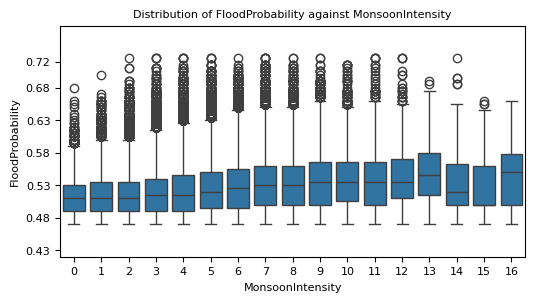

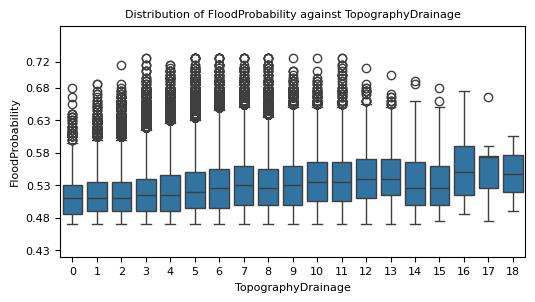

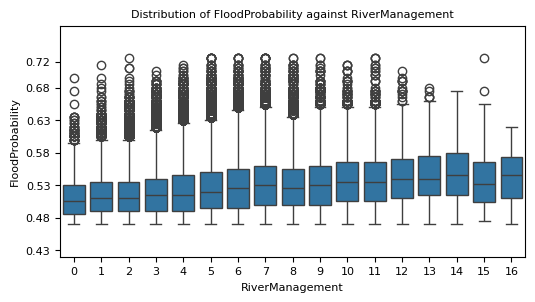

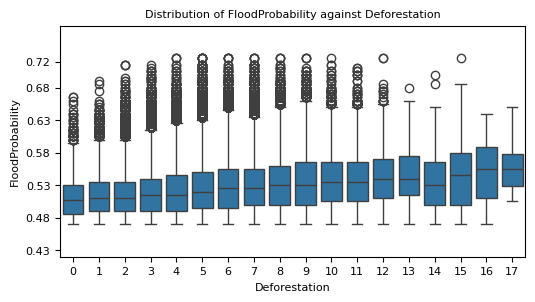

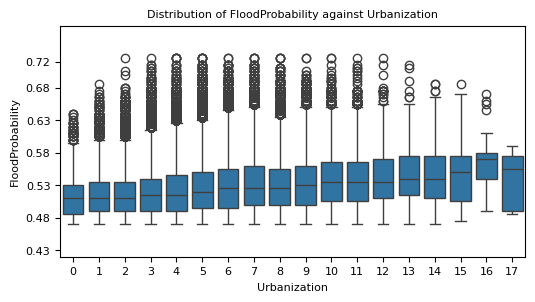

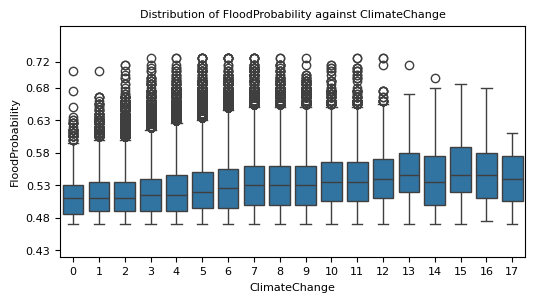

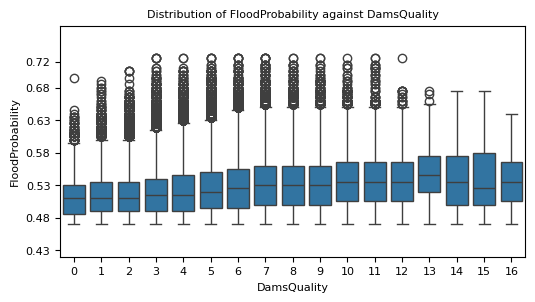

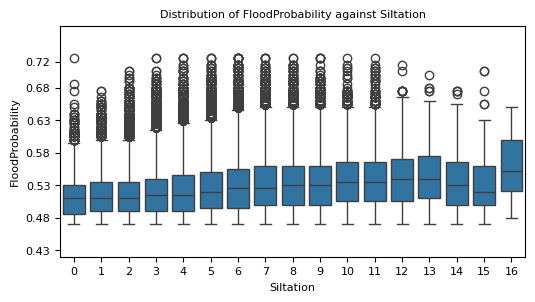

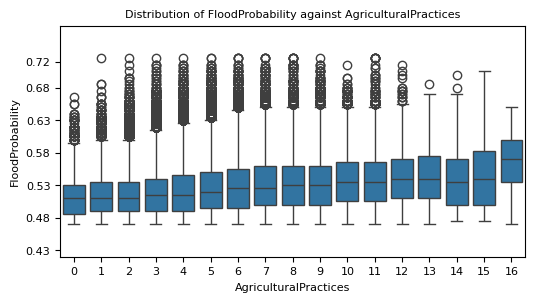

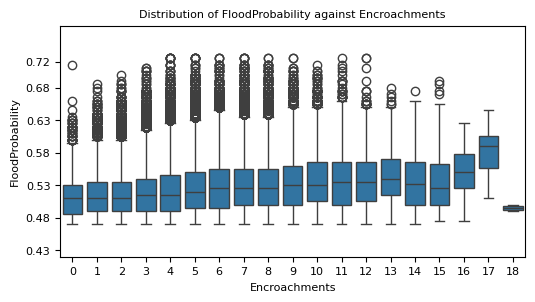

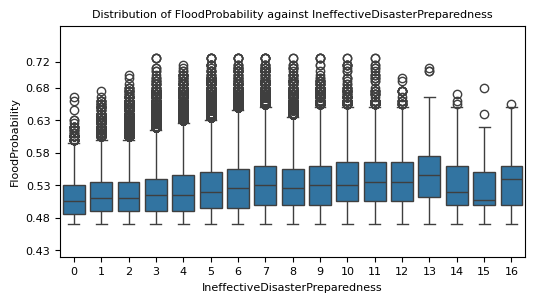

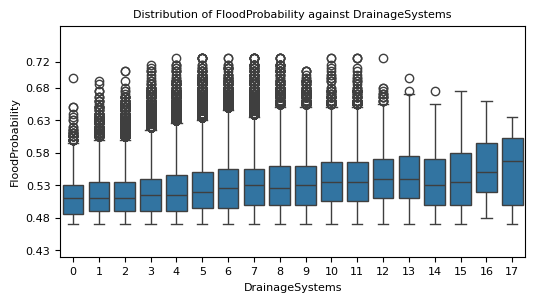

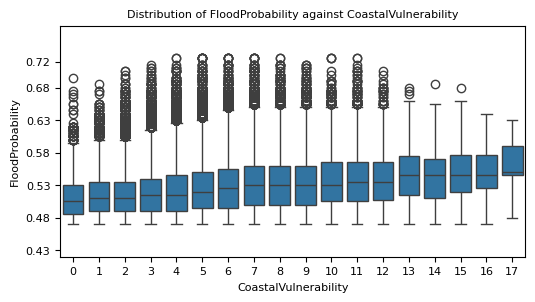

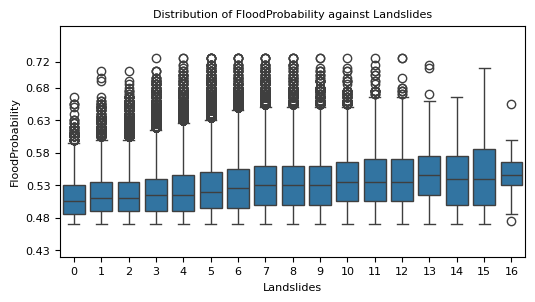

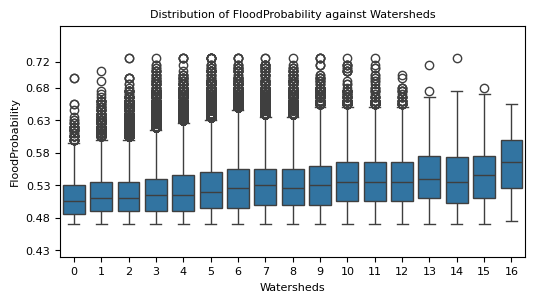

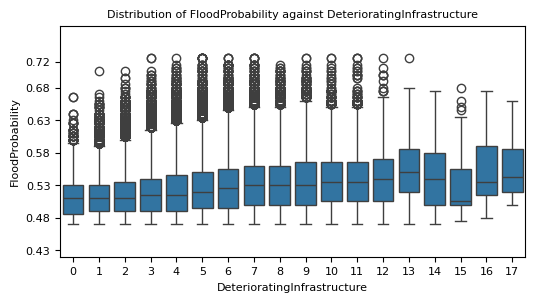

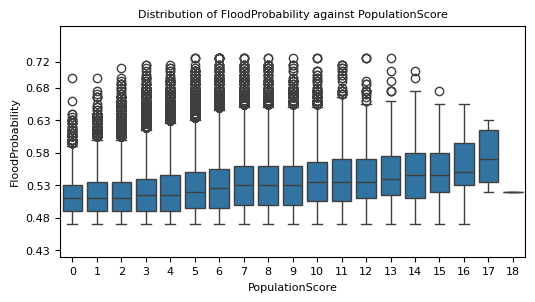

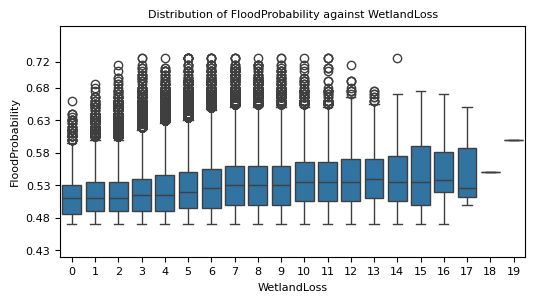

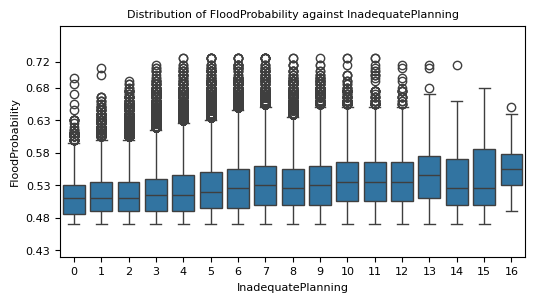

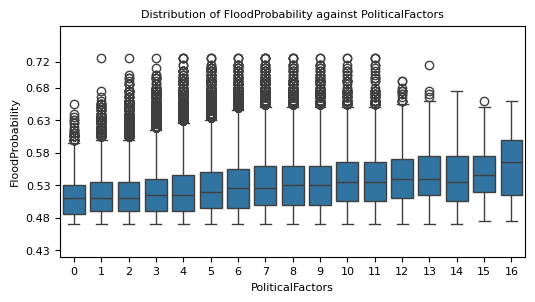

In [40]:
# boxplots for non-low cluster
for i in train_df_copy.columns:
    if i in ('id','FloodProbability','FloodProbability_labels'):
        pass 
    else:
        plot_boxplots(df=train_df_copy[train_df_copy['FloodProbability_labels']=='non-low'],
                      target='FloodProbability', 
                      variable=i)

<u> Notes: </u>

1. Hmm, not sure what to make of the results.
2. Doesn't seem like there is any solid indication of strong correlations between any of the features and the target variable, even when split between the low and non-low clusters.
3. From the heatmaps, it also doesn't seem like there are correlations between the features themselves. 
4. In other words, a flood probability of 0.50 could have multiple values of political factors, inadequate planning, population scores etc, of different rankings. This explains both the poor correlations between features AND between features and target variable.
5. Maybe if we added up the values, we would get a stronger correlation between the new summed feature and the target variable? Or maybe it would then be able to explain better the low and non-low clusters.

---

<a id='fe'></a>
### Feature engineering

In [41]:
# sum columns 
cols_to_sum = train_df_copy.columns.tolist()
cols_to_sum.remove('id')
cols_to_sum.remove('FloodProbability')
cols_to_sum.remove('FloodProbability_labels')

cols_to_sum

['MonsoonIntensity',
 'TopographyDrainage',
 'RiverManagement',
 'Deforestation',
 'Urbanization',
 'ClimateChange',
 'DamsQuality',
 'Siltation',
 'AgriculturalPractices',
 'Encroachments',
 'IneffectiveDisasterPreparedness',
 'DrainageSystems',
 'CoastalVulnerability',
 'Landslides',
 'Watersheds',
 'DeterioratingInfrastructure',
 'PopulationScore',
 'WetlandLoss',
 'InadequatePlanning',
 'PoliticalFactors']

In [42]:
# new column
train_df_copy['summation'] = train_df_copy[cols_to_sum].sum(axis=1)
train_df_copy['multiplication'] = train_df_copy[cols_to_sum].prod(axis=1)

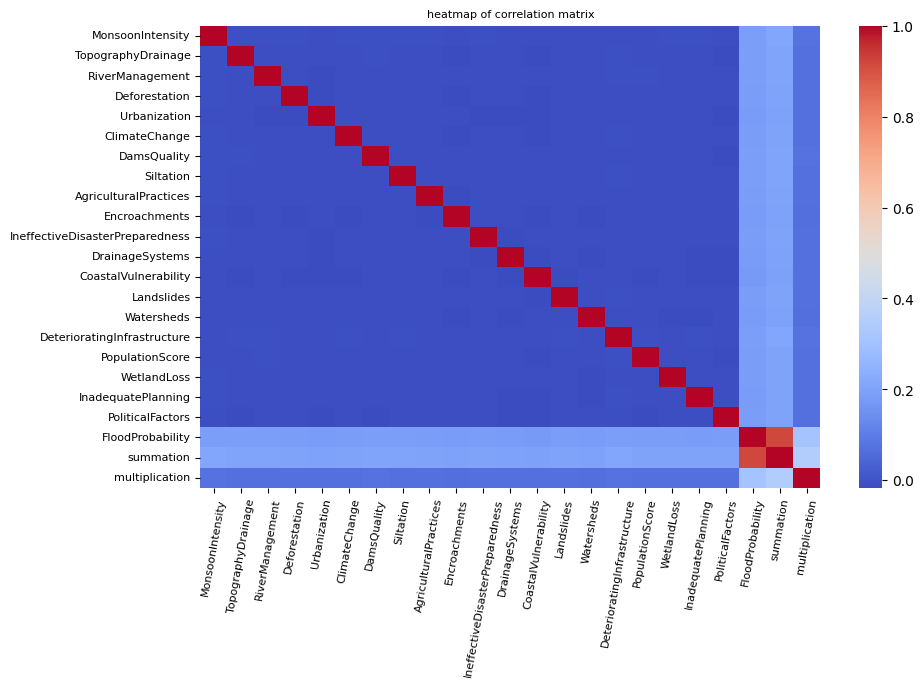

In [43]:
# correlation
corr = train_df_copy.drop(['id','FloodProbability_labels'], axis=1).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('heatmap of correlation matrix', fontsize=8)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8, rotation=80);

<u> Notes: </u>

1. The new features have medium to strong correlations with flood probability! 
2. `summation` has a pretty strong 0.8-0.9 correlation with flood probability while `multiplication` has a weaker 0.3-0.4 correlation, still relatively stronger than the original set of features.
3. At least we're getting somewhere...

---

### Fit models for predicting continuous target variable 

- Decision tree
- Random forest
- Extra trees 
- Ada boost
- Hyperparameter tuned using Optuna

In [44]:
# features and target variable 
y = 'FloodProbability'

exclude_from_X = ['FloodProbability','FloodProbability_labels']
X_cols = train_df_copy.columns.tolist()

for i in exclude_from_X:
    X_cols.remove(i)

X_df = train_df_copy[X_cols]
y_df = train_df_copy[y]

In [45]:
# split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(894365, 23) (223592, 23) (894365,) (223592,)


In [46]:
# store prediction results as each model is fitted and tested 
model_list = {}

# check variables against global symbol table
def get_variable_name(variable):
    names = [name for name, value in globals().items() if value is variable]
    return names[0] if names else None

def store_results(
        var: str,
        mse: int,
        r2: int
):
    key = get_variable_name(variable=var)
    model_list[key] = [mse, r2] 

<a id='de'></a>
### 1a. Decision tree

In [47]:
# instantiate 
de_model = DecisionTreeRegressor(random_state=1)

# evaluate with cv
scores = cross_val_score(de_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_score = scores.mean()

print(f"all scores: {scores}")
print(f"mean: {-mean_score}")

# fit and predict
de_model.fit(X_train, y_train)
de_model_y_pred = de_model.predict(X_test)

# evaluate 
def evaluate(
        actual_y: int,
        pred_y
):
    """ 
    Calculate mse and r^2

    """
    mse = mean_squared_error(actual_y, pred_y)
    r_square = round(r2_score(actual_y, pred_y),2)

    print(f"mse: {mse}; r2: {r_square}")
    return mse, r_square

mse, r2 = evaluate(y_test, de_model_y_pred)

# store results 
store_results(var=de_model, mse=mse, r2=r2)

model_list

all scores: [-0.00070524 -0.0007096  -0.00070461 -0.00069945 -0.0007014 ]
mean: 0.0007040615688225726
mse: 0.000701463491538159; r2: 0.73


{'de_model': [0.000701463491538159, 0.73]}

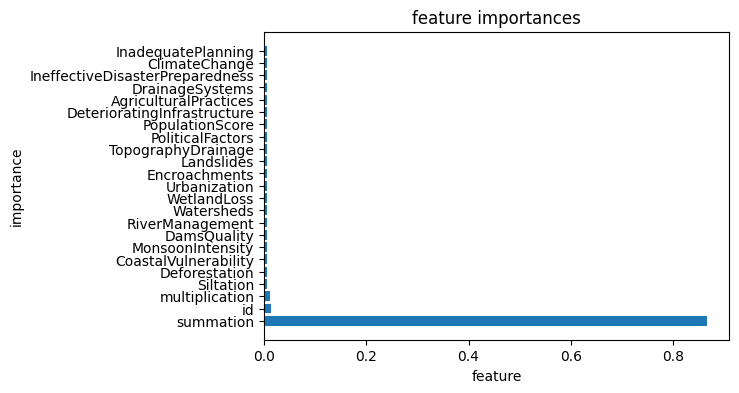

In [48]:
# feature importance 
feature_imp = de_model.feature_importances_
indices = np.argsort(feature_imp)[::-1]

# sort
sorted_features = [X_cols[i] for i in indices]
sorted_imp = feature_imp[indices]

# plot
plt.figure(figsize=(6,4))
plt.barh(range(len(sorted_imp)), sorted_imp, align="center")
plt.title('feature importances')
plt.ylabel("importance")
plt.xlabel("feature")
plt.yticks(range(len(sorted_features)), sorted_features, rotation=0);

In [49]:
# check params 
de_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 1,
 'splitter': 'best'}

<a id='de1'></a>
### 1b. Decision tree (hyperparameter tuning using Optuna)

- Define `objective` function to be optimized 
- Using `trial` object, suggest hyperparameter values to be tested
- Create a `study` object and invoke the `optimize` method

In [50]:
# implement steps above 
def de_objective(trial):
    # hyperparameters to tune 
    max_depth = trial.suggest_categorical('max_depth', np.arange(1, 10, 2).tolist() + [None])
    min_samples_split = trial.suggest_categorical('min_samples_split', np.arange(5, 100, 10).tolist() + [2])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', np.arange(5, 100, 10).tolist() + [1])
    max_features = trial.suggest_categorical('max_features', np.arange(2, 10, 1).tolist() + [None])

    # fit 
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=1
    )

    # evaluate 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = scores.mean()

    return -mean_score 


In [51]:
# run 
study = optuna.create_study(direction='minimize')
study.optimize(de_objective, n_trials=20)

# results 
de_model_tuned_best_trial = study.best_trial
de_model_tuned_best_params = de_model_tuned_best_trial.params 

print(f"best parameters: {de_model_tuned_best_params}")

[I 2024-06-17 21:54:23,350] A new study created in memory with name: no-name-74305828-a45a-4eef-96ff-37d9e9307928
[I 2024-06-17 21:54:36,141] Trial 0 finished with value: 0.0004959112845122115 and parameters: {'max_depth': 9, 'min_samples_split': 65, 'min_samples_leaf': 75, 'max_features': 8}. Best is trial 0 with value: 0.0004959112845122115.
[I 2024-06-17 21:54:47,467] Trial 1 finished with value: 0.0005026041456946812 and parameters: {'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 95, 'max_features': 9}. Best is trial 0 with value: 0.0004959112845122115.
[I 2024-06-17 21:55:00,125] Trial 2 finished with value: 0.0005495980067141456 and parameters: {'max_depth': None, 'min_samples_split': 75, 'min_samples_leaf': 15, 'max_features': 4}. Best is trial 0 with value: 0.0004959112845122115.
[I 2024-06-17 21:55:08,896] Trial 3 finished with value: 0.0005167731881508498 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 25, 'max_features': 5}. Best is 

best parameters: {'max_depth': None, 'min_samples_split': 15, 'min_samples_leaf': 85, 'max_features': 7}


In [52]:
# train decision tree again with best params 
de_model_tuned = DecisionTreeRegressor(**de_model_tuned_best_params, random_state=1)
de_model_tuned.fit(X_train, y_train)

de_model_tuned_y_pred = de_model_tuned.predict(X_test)

mse, r2 = evaluate(y_test, de_model_tuned_y_pred)

store_results(var=de_model_tuned, mse=mse, r2=r2)

mse: 0.0004040581796022701; r2: 0.85


In [53]:
model_list

{'de_model': [0.000701463491538159, 0.73],
 'de_model_tuned': [0.0004040581796022701, 0.85]}

<a id='rf'></a>
### 2a. Random forest

In [54]:
# instantiate 
rf_model = RandomForestRegressor(n_estimators=50, max_depth=3, n_jobs=-1, random_state=1)

# evaluate with cv
scores = cross_val_score(rf_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
mean_score = scores.mean()

print(f"all scores: {scores}")
print(f"mean: {-mean_score}")

# fit and predict 
rf_model.fit(X_train, y_train)
rf_model_y_pred = rf_model.predict(X_test)

# evaluate 
mse, r2 = evaluate(y_test, rf_model_y_pred)

# store results 
store_results(var=rf_model, mse=mse, r2=r2)

model_list


all scores: [-0.00041366 -0.00041117 -0.00040594]
mean: 0.00041025906327438687
mse: 0.0004115468964653116; r2: 0.84


{'de_model': [0.000701463491538159, 0.73],
 'de_model_tuned': [0.0004040581796022701, 0.85],
 'rf_model': [0.0004115468964653116, 0.84]}

In [55]:
# check params 
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 3,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

<a id='rf1'></a>
### 2b. Random forest (hyperparameter tuning)

In [56]:
# objective function
def rf_objective(trial):
    # hyperparameters to tune 
    max_depth = trial.suggest_categorical('max_depth', np.arange(1, 10, 2).tolist() + [None])
    min_samples_split = trial.suggest_categorical('min_samples_split', np.arange(2, 100, 2).tolist())
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', np.arange(1, 100, 1).tolist())
    max_features = trial.suggest_categorical('max_features', np.arange(1, 10, 1).tolist())
    max_leaf_nodes = trial.suggest_categorical('max_leaf_nodes', np.arange(10, 50, 10).tolist() + [None])
    max_samples = trial.suggest_categorical('max_samples', np.arange(0.5, 1.0, 0.2).tolist() + [None])
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0, 0.5)
    n_estimators = trial.suggest_categorical('n_estimators', [50, 100])    

    # fit 
    model = RandomForestRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        max_samples=max_samples,
        min_impurity_decrease=min_impurity_decrease,
        n_estimators=n_estimators,
        n_jobs=-1,
        random_state=1
    )
    
    # evaluate 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    mean_score = scores.mean()

    return -mean_score 


In [57]:
# run 
study = optuna.create_study(direction='minimize')
study.optimize(rf_objective, n_trials=20)

# results 
rf_model_tuned_best_trial = study.best_trial
rf_model_tuned_best_params = rf_model_tuned_best_trial.params 

print(f"best parameters: {rf_model_tuned_best_params}")

[I 2024-06-17 21:59:29,519] A new study created in memory with name: no-name-b17a7a18-4ccd-4c32-870f-b8e9401ee294
[I 2024-06-17 21:59:34,470] Trial 0 finished with value: 0.002600728077069729 and parameters: {'max_depth': 3, 'min_samples_split': 90, 'min_samples_leaf': 26, 'max_features': 2, 'max_leaf_nodes': 30, 'max_samples': 0.5, 'min_impurity_decrease': 0.06241198561269529, 'n_estimators': 100}. Best is trial 0 with value: 0.002600728077069729.
[I 2024-06-17 21:59:39,543] Trial 1 finished with value: 0.0026007283179503185 and parameters: {'max_depth': 5, 'min_samples_split': 44, 'min_samples_leaf': 37, 'max_features': 4, 'max_leaf_nodes': 30, 'max_samples': None, 'min_impurity_decrease': 0.00889756484219495, 'n_estimators': 50}. Best is trial 0 with value: 0.002600728077069729.
[I 2024-06-17 21:59:42,389] Trial 2 finished with value: 0.0026007289296715104 and parameters: {'max_depth': 5, 'min_samples_split': 98, 'min_samples_leaf': 72, 'max_features': 1, 'max_leaf_nodes': 20, 'max_

best parameters: {'max_depth': 9, 'min_samples_split': 60, 'min_samples_leaf': 80, 'max_features': 6, 'max_leaf_nodes': 10, 'max_samples': None, 'min_impurity_decrease': 0.49858204774422465, 'n_estimators': 100}


In [58]:
# train decision tree again with best params 
rf_model_tuned = RandomForestRegressor(**rf_model_tuned_best_params, random_state=1)
rf_model_tuned.fit(X_train, y_train)

rf_model_tuned_y_pred = rf_model_tuned.predict(X_test)

mse, r2 = evaluate(y_test, rf_model_tuned_y_pred)

store_results(var=rf_model_tuned, mse=mse, r2=r2)

model_list

mse: 0.002615470936961325; r2: -0.0


{'de_model': [0.000701463491538159, 0.73],
 'de_model_tuned': [0.0004040581796022701, 0.85],
 'rf_model': [0.0004115468964653116, 0.84],
 'rf_model_tuned': [0.002615470936961325, -0.0]}

<a id='et'></a>
### 3a. Extra trees

In [59]:
# instantiate 
et_model = ExtraTreesRegressor(n_estimators=50, n_jobs=-1, random_state=1)

# evaluate with cv
scores = cross_val_score(et_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_score = scores.mean()

print(f"all scores: {scores}")
print(f"mean: {-mean_score}")

# fit and predict 
et_model.fit(X_train, y_train)
et_model_y_pred = et_model.predict(X_test)

# evaluate 
mse, r2 = evaluate(y_test, et_model_y_pred)

# store results 
store_results(var=et_model, mse=mse, r2=r2)

model_list

all scores: [-0.00035285 -0.00035354 -0.00035229 -0.00035244 -0.00035317]
mean: 0.0003528586571478089
mse: 0.0003518047956993096; r2: 0.87


{'de_model': [0.000701463491538159, 0.73],
 'de_model_tuned': [0.0004040581796022701, 0.85],
 'rf_model': [0.0004115468964653116, 0.84],
 'rf_model_tuned': [0.002615470936961325, -0.0],
 'et_model': [0.0003518047956993096, 0.87]}

In [60]:
et_model.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

<a id='et1'></a>
### 3b. Extra trees (hyperparameter tuning)

In [61]:
# objective function
def et_objective(trial):
    # hyperparameters to tune 
    n_estimators = trial.suggest_categorical('n_estimators', [20, 50, 100])    
    max_depth = trial.suggest_categorical('max_depth', [None, 3, 10, 20]) 
    max_features = trial.suggest_categorical('max_features', [1, 3, 6, 10])
    max_leaf_nodes = trial.suggest_categorical('max_leaf_nodes', [None, 10, 20])
    min_impurity_decrease = trial.suggest_categorical('min_impurity_decrease', [0, 0.5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 50, 100])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 50, 100])

    # fit 
    model = ExtraTreesRegressor(
        max_depth=max_depth,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        n_jobs=-1,
        random_state=1
    )

    # evaluate 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = scores.mean()

    return -mean_score 

In [62]:
# run 
study = optuna.create_study(direction='minimize')
study.optimize(et_objective, n_trials=20)

# results 
et_model_tuned_best_trial = study.best_trial
et_model_tuned_best_params = et_model_tuned_best_trial.params 

print(f"best parameters: {et_model_tuned_best_params}")

[I 2024-06-17 22:11:47,626] A new study created in memory with name: no-name-13c8a86f-41b8-4006-9706-64b1092eebee
[I 2024-06-17 22:11:50,038] Trial 0 finished with value: 0.0026007143182567487 and parameters: {'n_estimators': 20, 'max_depth': 20, 'max_features': 1, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.5, 'min_samples_leaf': 50, 'min_samples_split': 100}. Best is trial 0 with value: 0.0026007143182567487.
[I 2024-06-17 22:11:55,850] Trial 1 finished with value: 0.002150020085012995 and parameters: {'n_estimators': 50, 'max_depth': 3, 'max_features': 3, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 100, 'min_samples_split': 100}. Best is trial 1 with value: 0.002150020085012995.
[I 2024-06-17 22:11:59,722] Trial 2 finished with value: 0.002362931557732967 and parameters: {'n_estimators': 50, 'max_depth': None, 'max_features': 1, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0, 'min_samples_leaf': 50, 'min_samples_split': 100}. Best is trial 1 with

best parameters: {'n_estimators': 100, 'max_depth': 20, 'max_features': 6, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 100}


In [63]:
# train with best params
et_model_tuned = ExtraTreesRegressor(**et_model_tuned_best_params, random_state=1)
et_model_tuned.fit(X_train, y_train)

et_model_tuned_y_pred = et_model_tuned.predict(X_test)

mse, r2 = evaluate(y_test, et_model_tuned_y_pred)

store_results(var=et_model_tuned, mse=mse, r2=r2)

model_list

mse: 0.0004061123813913048; r2: 0.84


{'de_model': [0.000701463491538159, 0.73],
 'de_model_tuned': [0.0004040581796022701, 0.85],
 'rf_model': [0.0004115468964653116, 0.84],
 'rf_model_tuned': [0.002615470936961325, -0.0],
 'et_model': [0.0003518047956993096, 0.87],
 'et_model_tuned': [0.0004061123813913048, 0.84]}

<a id='ab'></a>
### 4a. Ada boost

In [64]:
# base estimator 
# base_est = DecisionTreeRegressor(random_state=1)

# ada boost regressor 
ab_model = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, random_state=1)

# evaluate with cv 
scores = cross_val_score(ab_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_score = scores.mean() 

print(f"all scores: {scores}")
print(f"mean: {-mean_score}")

# fit and predict 
ab_model.fit(X_train, y_train)
ab_model_y_pred = ab_model.predict(X_test)

# evaluate 
mse, r2 = evaluate(y_test, ab_model_y_pred)

# store 
store_results(var=ab_model, mse=mse, r2=r2)

model_list


all scores: [-0.00040865 -0.00048124 -0.00061539 -0.00063224 -0.00051869]
mean: 0.0005312417160250127
mse: 0.0006541070116415246; r2: 0.75


{'de_model': [0.000701463491538159, 0.73],
 'de_model_tuned': [0.0004040581796022701, 0.85],
 'rf_model': [0.0004115468964653116, 0.84],
 'rf_model_tuned': [0.002615470936961325, -0.0],
 'et_model': [0.0003518047956993096, 0.87],
 'et_model_tuned': [0.0004061123813913048, 0.84],
 'ab_model': [0.0006541070116415246, 0.75]}

In [65]:
ab_model.get_params()

{'estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': 1}

<a id='ab1'></a>
### 4b. Ada boost (hyperparameter tuning)

In [66]:
# objective function
def ab_objective(trial):
    # hyperparameters to tune 
    n_estimators = trial.suggest_categorical('n_estimators', [50])
    learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.1, 0.5, 1.0])

    # ada boost
    model = AdaBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=1
    )

    # evaluate with cv 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = scores.mean()

    return -mean_score 


In [67]:
# run 
study = optuna.create_study(direction='minimize')
study.optimize(ab_objective, n_trials=5)

# results 
ab_model_tuned_best_trial = study.best_trial
ab_model_tuned_best_params = ab_model_tuned_best_trial.params 

print(f"best parameters: {ab_model_tuned_best_params}")

[I 2024-06-17 22:42:03,798] A new study created in memory with name: no-name-105016d5-93ef-438d-99f4-7aa1db39e648
[I 2024-06-17 22:49:58,504] Trial 0 finished with value: 0.0005312417160250127 and parameters: {'n_estimators': 50, 'learning_rate': 1.0}. Best is trial 0 with value: 0.0005312417160250127.
[I 2024-06-17 23:01:09,095] Trial 1 finished with value: 0.0004772580216856081 and parameters: {'n_estimators': 50, 'learning_rate': 0.5}. Best is trial 1 with value: 0.0004772580216856081.
[I 2024-06-17 23:08:56,862] Trial 2 finished with value: 0.0005312417160250127 and parameters: {'n_estimators': 50, 'learning_rate': 1.0}. Best is trial 1 with value: 0.0004772580216856081.
[I 2024-06-17 23:22:58,389] Trial 3 finished with value: 0.0003805513976247863 and parameters: {'n_estimators': 50, 'learning_rate': 0.1}. Best is trial 3 with value: 0.0003805513976247863.
[I 2024-06-17 23:36:53,532] Trial 4 finished with value: 0.0004117086338646785 and parameters: {'n_estimators': 50, 'learning_

best parameters: {'n_estimators': 50, 'learning_rate': 0.1}


In [68]:
# train decision tree again with best params 
ab_model_tuned = AdaBoostRegressor(**ab_model_tuned_best_params, random_state=1)
ab_model_tuned.fit(X_train, y_train)

ab_model_tuned_y_pred = ab_model_tuned.predict(X_test)

mse, r2 = evaluate(y_test, ab_model_tuned_y_pred)

store_results(var=ab_model_tuned, mse=mse, r2=r2)

model_list

mse: 0.00037921655711186763; r2: 0.86


{'de_model': [0.000701463491538159, 0.73],
 'de_model_tuned': [0.0004040581796022701, 0.85],
 'rf_model': [0.0004115468964653116, 0.84],
 'rf_model_tuned': [0.002615470936961325, -0.0],
 'et_model': [0.0003518047956993096, 0.87],
 'et_model_tuned': [0.0004061123813913048, 0.84],
 'ab_model': [0.0006541070116415246, 0.75],
 'ab_model_tuned': [0.00037921655711186763, 0.86]}

<u> Notes: </u>

1. Interestingly, the pre-pruned decision tree and extra tree regressors performed the best
2. When looking at the results on both the training and test sets, we don't see massive overfitting either

---

<a id='postprune'></a>
### Post-prune decision tree using cost complexity penalty

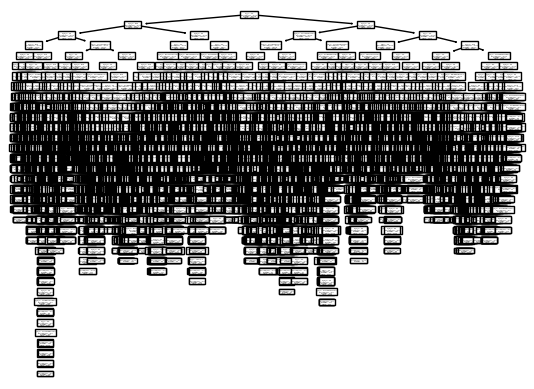

In [69]:
# rough plot of tree diagram
tree.plot_tree(de_model_tuned)
plt.show()

In [70]:
# params
de_model_tuned.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 7,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 85,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 1,
 'splitter': 'best'}

In [71]:
# ccp alphas 
path = de_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


In [72]:
ccp_alphas.shape # there are way too many penalties to test

(329460,)

In [73]:
# even the highest isn't that high of a penalty
print(f"lowest ccp_alpha: {ccp_alphas.min()}; highest: {ccp_alphas.max()}") 

lowest ccp_alpha: 0.0; highest: 0.001519547271933768


In [76]:
# get 5 alphas of equal width between 0 and 0.0015 to test, just for the sake of it 
modified_ccp_alphas = np.linspace(0, 0.001519547271933768, 5)

modified_ccp_alphas

array([0.        , 0.00037989, 0.00075977, 0.00113966, 0.00151955])

In [78]:
# test
de_model_tuned_post_list = []

for i, alpha in enumerate(modified_ccp_alphas):
    # train decision tree again with best params 
    print(f"current trial: {i+1}")
    de_model_tuned_post = DecisionTreeRegressor(ccp_alpha=alpha, random_state=1)
    de_model_tuned_post.fit(X_train, y_train) # without cv this time
    de_model_tuned_post_list.append(de_model_tuned_post)

current trial: 1
current trial: 2
current trial: 3
current trial: 4
current trial: 5


In [85]:
# track evaluation
train_results = []
test_results = []

for index, model in enumerate(de_model_tuned_post_list):
    print(f"training {index+1}: {model}")
    # predict for train and test set
    y_train_pred_ = model.predict(X_train)
    y_test_pred_ = model.predict(X_test)
    # evaluate and store results
    mse_train, r2_train = evaluate(y_train, y_train_pred_)
    mse_test, r2_test = evaluate(y_test, y_test_pred_)
    
    train_results.append((mse_train, r2_train))
    test_results.append((mse_test, r2_test))
    print('\n')


training 1: DecisionTreeRegressor(random_state=1)
mse: 2.6524245752414293e-32; r2: 1.0
mse: 0.000701463491538159; r2: 0.73


training 2: DecisionTreeRegressor(ccp_alpha=0.000379886817983442, random_state=1)
mse: 0.0010811605707347197; r2: 0.58
mse: 0.0010881154260834786; r2: 0.58


training 3: DecisionTreeRegressor(ccp_alpha=0.000759773635966884, random_state=1)
mse: 0.0010811605707347197; r2: 0.58
mse: 0.0010881154260834786; r2: 0.58


training 4: DecisionTreeRegressor(ccp_alpha=0.001139660453950326, random_state=1)
mse: 0.0010811605707347197; r2: 0.58
mse: 0.0010881154260834786; r2: 0.58


training 5: DecisionTreeRegressor(ccp_alpha=0.001519547271933768, random_state=1)
mse: 0.002600707842671644; r2: -0.0
mse: 0.0026154705103953184; r2: -0.0




In [86]:
model_list

{'de_model': [0.000701463491538159, 0.73],
 'de_model_tuned': [0.0004040581796022701, 0.85],
 'rf_model': [0.0004115468964653116, 0.84],
 'rf_model_tuned': [0.002615470936961325, -0.0],
 'et_model': [0.0003518047956993096, 0.87],
 'et_model_tuned': [0.0004061123813913048, 0.84],
 'ab_model': [0.0006541070116415246, 0.75],
 'ab_model_tuned': [0.00037921655711186763, 0.86]}

<u> Notes: </u>

1. We will use the Extra Trees regressor as the final model for prediction

---

<a id='pred'></a>
### Predict test set

In [92]:
# apply feature engineering 
test_df.columns

Index(['id', 'MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors'],
      dtype='object')

In [93]:
# remove id
# test_df.pop('id')

# add new columns 
test_df['summation'] = test_df[cols_to_sum].sum(axis=1) # cols_to_sum from before
test_df['multiplication'] = test_df[cols_to_sum].prod(axis=1)

test_df.shape

(745305, 23)

In [94]:
X_test.shape

(223592, 23)

In [97]:
# predict
results = test_df[['id']]

results['FloodProbability'] = et_model.predict(test_df)

/var/folders/90/mryc4l_s7tx2jy79tq3yy2gc0000gn/T/ipykernel_21836/3238180873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['FloodProbability'] = et_model.predict(test_df)


In [98]:
results

id  FloodProbability
0       1117957            0.5763
1       1117958            0.4498
2       1117959            0.4510
3       1117960            0.4710
4       1117961            0.4770
...         ...               ...
745300  1863257            0.4782
745301  1863258            0.4405
745302  1863259            0.6208
745303  1863260            0.5532
745304  1863261            0.5375

[745305 rows x 2 columns]

In [100]:
results.to_csv('./dataset/floodpred_submission.csv', index=False)

In [102]:
from IPython.display import HTML

def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='./dataset/floodpred_submission.csv')

---